# Google Analytics Customer Revenue

### Import base libraries

In [1]:
import sys 

import os 
import random

import numpy as np 
import pandas as pd 

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 

# Necesarios para leer el fichero de Google Analytics
import json 
from pandas.io.json import json_normalize 

pd.options.display.max_rows = 999

plt.style.use('ggplot')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import linear_model
import lightgbm as lgb
import xgboost as xgb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz

/Users/juan/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
RANDOM_STATE = 42

In [4]:
file_dir = '/Users/juan/Desktop/ga-customer-revenue-prediction/'

In [7]:
## Función de lectura 
columns = ['device', 'geoNetwork', 'totals', 'trafficSource'] # Columns with json format

p = 1 # Fraction of data to use

def json_read(df):
    data_frame = file_dir + df
    
    df = pd.read_csv(data_frame, 
                     converters={column: json.loads for column in columns}, 
                     dtype={'fullVisitorId': 'str'}, 
                     skiprows=lambda i: i>0 and random.random() > p)
    
    for column in columns: 
        column_as_df = json_normalize(df[column]) 
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    print(f"Loaded {os.path.basename(data_frame)}. Shape: {df.shape}")
    return df 

In [6]:
%%time
file_name = 'train.csv'
df = json_read(file_name)

Loaded train.csv. Shape: (903653, 55)
CPU times: user 2min 6s, sys: 8.74 s, total: 2min 15s
Wall time: 2min 14s


In [ ]:
oo

In [6]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Columns: 55 entries, channelGrouping to trafficSource.campaignCode
dtypes: bool(1), int64(4), object(50)
memory usage: 373.2+ MB


In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserVersion                                903653 non-null object
device.browserSize                                   903653 non-null object
device.operatingSystem                               9036

In [8]:
index = ['fullVisitorId', 'visitId']
df.set_index(index, inplace=True)

In [9]:
df.drop('sessionId', axis=1, inplace=True)

In [10]:
df.head().T

fullVisitorId,1131660440785968503,377306020877927890,3895546263509774583,4763447161404445595,27294437909732085
visitId,1472830385,1472880147,1472865386,1472881213,1472822600
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
date,20160902,20160902,20160902,20160902,20160902
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitNumber,1,1,1,1,2
visitStartTime,1472830385,1472880147,1472865386,1472881213,1472822600
device.browser,Chrome,Firefox,Chrome,UC Browser,Chrome
device.browserVersion,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset
device.browserSize,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset
device.operatingSystem,Windows,Macintosh,Windows,Linux,Android


In [11]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
date,903653.0,2.016589e+07,4.697698e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
visitNumber,903653.0,2.264897e+00,9.283735e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.950000e+02
visitStartTime,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09


In [12]:
df.describe??

In [13]:
df.describe(exclude=np.number).T

,count,unique,top,freq
channelGrouping,903653,8,Organic Search,381561
socialEngagementType,903653,1,Not Socially Engaged,903653
device.browser,903653,54,Chrome,620364
device.browserVersion,903653,1,not available in demo dataset,903653
device.browserSize,903653,1,not available in demo dataset,903653
device.operatingSystem,903653,20,Windows,350072
device.operatingSystemVersion,903653,1,not available in demo dataset,903653
device.isMobile,903653,2,False,664530
device.mobileDeviceBranding,903653,1,not available in demo dataset,903653
device.mobileDeviceModel,903653,1,not available in demo dataset,903653


In [14]:
# constant_columns []

# for column in df.columns:
#    if df[column].nunique() == 1 
#        constant_columns.append(column)

In [15]:
constant_columns = [column for column in df.columns if df[column].nunique() == 1]

In [16]:
constant_columns

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']

In [17]:
df.drop(constant_columns, axis=1, inplace=True)

In [18]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 903653 entries, (1131660440785968503, 1472830385) to (0814900163617805053, 1483574474)
Columns: 28 entries, channelGrouping to trafficSource.adContent
dtypes: bool(1), int64(3), object(24)
memory usage: 206.1+ MB


In [19]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 903653 entries, (1131660440785968503, 1472830385) to (0814900163617805053, 1483574474)
Data columns (total 28 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null object
device.operatingSystem                          903653 non-null object
device.isMobile                                 903653 non-null bool
device.deviceCategory                           903653 non-null object
geoNetwork.continent                            903653 non-null object
geoNetwork.subContinent                         903653 non-null object
geoNetwork.country                              903653 non-null object
geoNetwork.region                               903653

## EDA

In [20]:
initial_description = df.describe(include='all').T

In [21]:
# initial_description.to_excel('initial_description.xlsx')

#### Analyze the target feature

In [22]:
TARGET = 'totals.transactionRevenue'

In [23]:
df[TARGET].describe()

count        11515
unique        5332
top       16990000
freq           256
Name: totals.transactionRevenue, dtype: object

In [24]:
df[df[TARGET].notnull()][TARGET].head().T

fullVisitorId        visitId   
6194193421514403509  1472843572     37860000
5327166854580374902  1472844906    306670000
8885051388942907862  1472827393     68030000
0185467632009737931  1472846398     26250000
3244885836845029978  1472824817    574150000
Name: totals.transactionRevenue, dtype: object

In [25]:
df[TARGET] = df[TARGET].astype(float)

In [26]:
df[TARGET].fillna(0.0, inplace=True)

In [27]:
df[TARGET] = df[TARGET] / 1000000

In [28]:
df[df[TARGET] > 0][TARGET].head().T

fullVisitorId        visitId   
6194193421514403509  1472843572     37.86
5327166854580374902  1472844906    306.67
8885051388942907862  1472827393     68.03
0185467632009737931  1472846398     26.25
3244885836845029978  1472824817    574.15
Name: totals.transactionRevenue, dtype: float64

In [29]:
df[TARGET].describe()

count    903653.000000
mean          1.704273
std          52.778659
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       23129.500000
Name: totals.transactionRevenue, dtype: float64

In [30]:
df[df[TARGET] > 0][TARGET].describe()

count    11515.000000
mean       133.744789
std        448.285227
min          0.010000
25%         24.930000
50%         49.450000
75%        107.655000
max      23129.500000
Name: totals.transactionRevenue, dtype: float64

In [31]:
df['totals.withTransaction'] = (df[TARGET] > 0).astype(int)

In [32]:
print('Transacciones con importe')
100 * df['totals.withTransaction'].value_counts() / df['totals.withTransaction'].count()

Transacciones con importe


0    98.725728
1     1.274272
Name: totals.withTransaction, dtype: float64

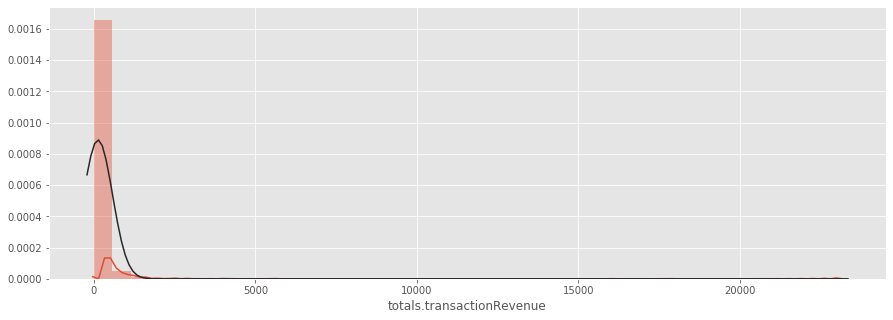

In [33]:
plt.figure(figsitransaze=(15,5))
sns.distplot(
    df[df['totals.withTransaction'] == 1][TARGET],
    bins=40,
    fit=stats.norm
)

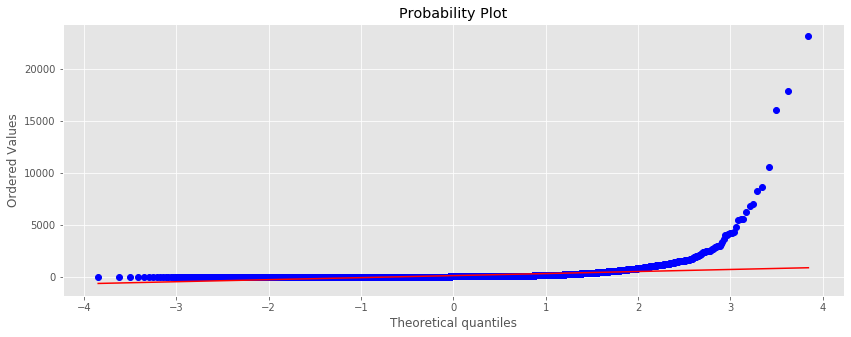

In [34]:
plt.figure(figsize=(14, 5))
res = stats.probplot(df[df['totals.withTransaction'] == 1][TARdf.headGET], plot=plt)

In [35]:
df['totals.transactionRevenueLN'] = df['totals.transactionRevenue'].apply(lambda x: np.log1p(x))

In [36]:
LN_TARGET = 'totals.transactionRevenueLN'

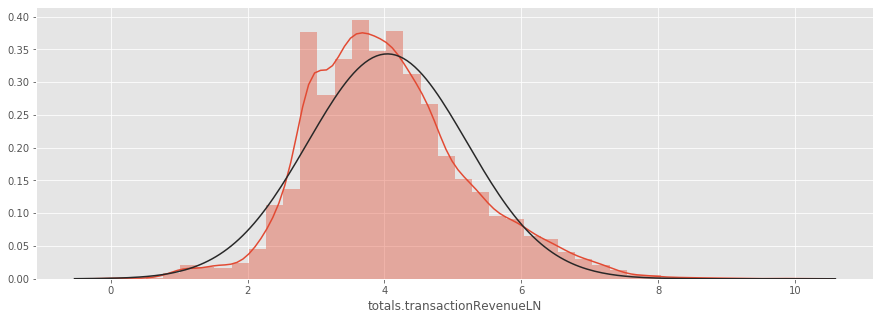

In [37]:
plt.figure(figsize=(15,5))
sns.distplot(
    df[df['totals.withTransaction'] == 1][LN_TARGET],
    bins=40,
    fit=stats.norm
)

In [38]:
df[LN_TARGET].describe()

count    903653.000000
mean          0.051507
std           0.471994
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.048907
Name: totals.transactionRevenueLN, dtype: float64

In [39]:
df[df['totals.withTransaction'] == 1][LN_TARGET].describe()

count    11515.000000
mean         4.042088
std          1.163013
min          0.009950
25%          3.255401
50%          3.920983
75%          4.688177
max         10.048907
Name: totals.transactionRevenueLN, dtype: float64

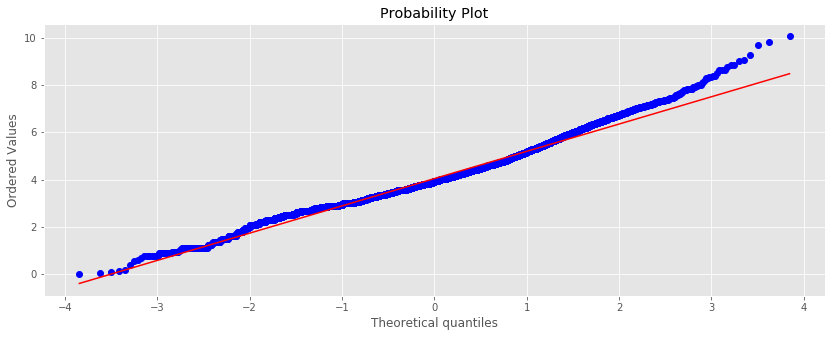

In [40]:
plt.figure(figsize=(14, 5))
res = stats.probplot(df[df['totals.withTransaction'] == 1][LN_TARGET], plot=plt)

In [41]:
def outliers(Serie):
    serie_mean = Serie.mean()
    serie_std  = Serie.std()
    
    margin = 3 * serie_std
    
    lower_bound = serie_mean - margin
    upper_b##ound = serie_mean + margin 
    
    outliers_lower = [x for x in Serie if x < lower_bound]
    outliers_upper = [x for x in Serie if x > upper_bound] 
    
    print('Lower Bound Outliers: {}'.format(len(outliers_lower)))
    print('Upper Bound Outliers: {}'.format(len(outliers_upper)))

In [42]:
outliers(df[df['totals.withTransaction']==1][LN_TARGET])

Lower Bound Outliers: 6
Upper Bound Outliers: 53


In [43]:
df[LN_TARGET].describe()

count    903653.000000
mean          0.051507
std           0.471994
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.048907
Name: totals.transactionRevenueLN, dtype: float64

In [44]:
df[df['totals.withTransaction']==1][LN_TARGET].describe()

count    11515.000000
mean         4.042088
std          1.163013
min          0.009950
25%          3.255401
50%          3.920983
75%          4.688177
max         10.048907
Name: totals.transactionRevenueLN, dtype: float64

#### Hits

In [45]:
df['totals.hits'].describe()

count     903653
unique       274
top            1
freq      446754
Name: totals.hits, dtype: object

In [46]:
df['totals.hits'].value_counts(dropna=False)

1      446754
2      137952
3       70402
4       42444
5       30939
6       23918
7       19518
8       15484
9       12959
10      10640
11       9264
12       7879
13       6881
14       6194
15       5384
16       4716
17       4130
18       3755
19       3291
20       3064
21       2798
22       2477
23       2190
24       2126
25       1925
26       1718
27       1504
28       1406
29       1291
30       1289
31       1104
32       1088
33        944
34        846
35        845
36        785
37        745
38        724
39        693
40        621
41        553
42        527
43        501
44        454
45        438
46        424
47        363
48        349
49        348
51        333
50        316
53        269
52        261
54        246
55        227
57        212
56        211
60        206
59        203
61        198
58        193
62        178
65        156
64        156
63        145
66        141
69        122
71        122
67        119
73        117
68        110
74    

In [47]:
df['totals.hits'] = df['totals.hits'].astype(int)

In [48]:
df['totals.hits'].describe()

count    903653.000000
mean          4.596538
std           9.641437
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         500.000000
Name: totals.hits, dtype: float64

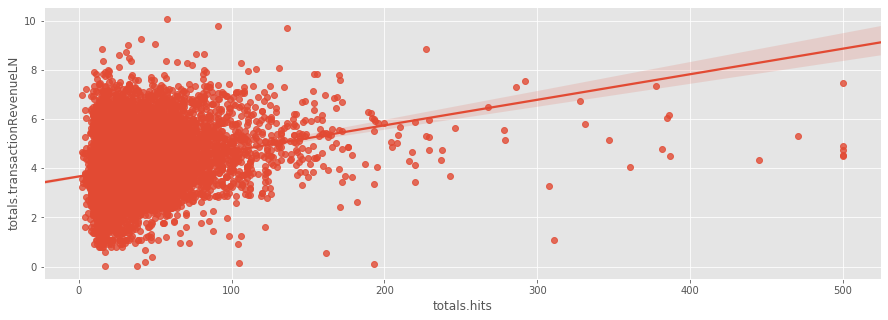

In [49]:
plt.figure(figsize=(15,5))
sns.regplot(
    x = 'totals.hits',
    y = LN_TARGET,
    data = df[df['totals.withTransaction'] == 1]
)

In [50]:
df['totals.hitsLN'] = df['totals.hits'].apply(lambda x: np.log1p(x))

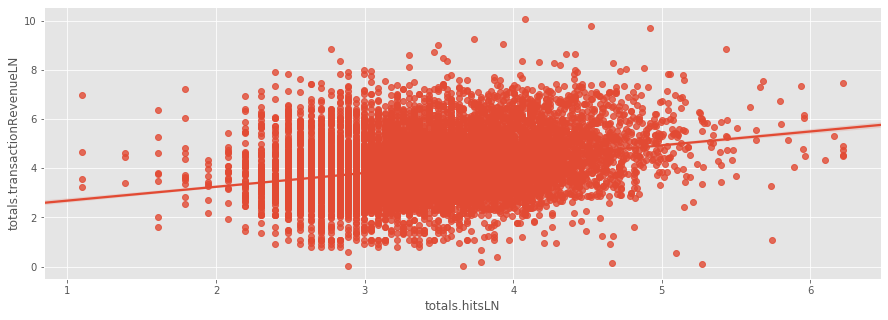

In [51]:
plt.figure(figsize=(15,5))
sns.regplot(
    x = 'totals.hitsLN',
    y = LN_TARGET,
    data = df[df['totals.withTransaction'] == 1]
)

### Date

In [52]:
df['date'].head()

fullVisitorId        visitId   
1131660440785968503  1472830385    20160902
377306020877927890   1472880147    20160902
3895546263509774583  1472865386    20160902
4763447161404445595  1472881213    20160902
27294437909732085    1472822600    20160902
Name: date, dtype: int64

In [53]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [54]:
df['date'].head()

fullVisitorId        visitId   
1131660440785968503  1472830385   2016-09-02
377306020877927890   1472880147   2016-09-02
3895546263509774583  1472865386   2016-09-02
4763447161404445595  1472881213   2016-09-02
27294437909732085    1472822600   2016-09-02
Name: date, dtype: datetime64[ns]

In [55]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekDay'] = df['date'].dt.weekday
df['quarter'] = df['date'].dt.quarter
df['week'] = df['date'].dt.week 

In [56]:
df.head(1).T

fullVisitorId,1131660440785968503
visitId,1472830385
channelGrouping,Organic Search
date,2016-09-02 00:00:00
visitNumber,1
visitStartTime,1472830385
device.browser,Chrome
device.operatingSystem,Windows
device.isMobile,False
device.deviceCategory,desktop
geoNetwork.continent,Asia


In [57]:
df.drop('date', axis=1, inplace=True)

In [58]:
df['visitStartTime'].head()

fullVisitorId        visitId   
1131660440785968503  1472830385    1472830385
377306020877927890   1472880147    1472880147
3895546263509774583  1472865386    1472865386
4763447161404445595  1472881213    1472881213
27294437909732085    1472822600    1472822600
Name: visitStartTime, dtype: int64

In [59]:
datetime.fromtimestamp(1472830385).hour

17

In [60]:
df['visitHour'] = df['visitStartTime'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [61]:
df['visitHour'].head()

fullVisitorId        visitId   
1131660440785968503  1472830385    17
377306020877927890   1472880147     7
3895546263509774583  1472865386     3
4763447161404445595  1472881213     7
27294437909732085    1472822600    15
Name: visitHour, dtype: int64

In [62]:
df.drop('visitStartTime', axis=1, inplace=True)

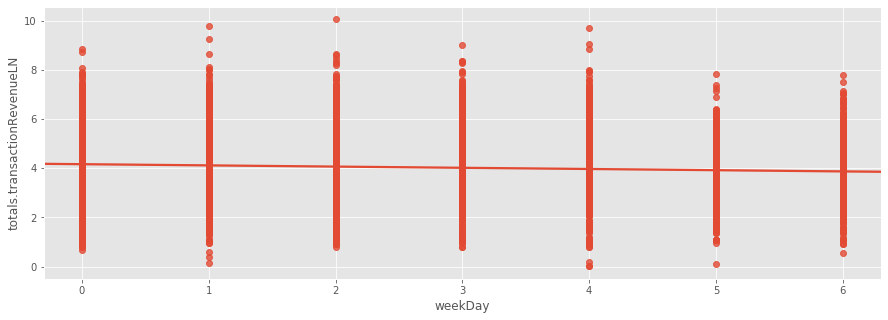

In [63]:
plt.figure(figsize=(15,5))
sns.regplot(
    x = 'weekDay',
    y = LN_TARGET,
    data = df[df['totals.withTransaction'] == 1]
)

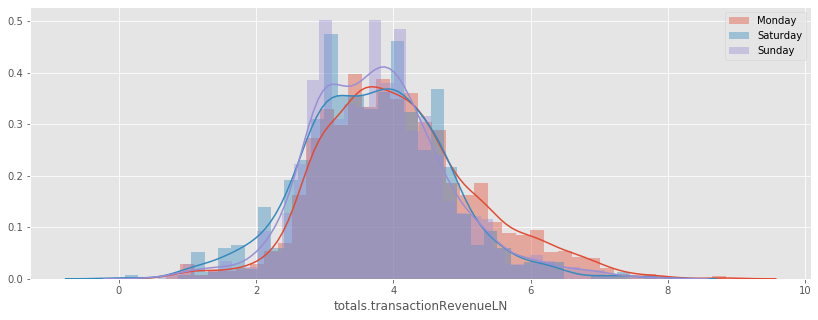

In [64]:
plt.figure(figsize=(14,5))
sns.distplot(
    df[(df['totals.withTransaction'] == 1) & (df['weekDay'] == 0)]['totals.transactionRevenueLN'], 
    bins=40, 
    kde=True,
    label='Monday'
    )
sns.distplot(
    df[(df['totals.withTransaction'] == 1) & (df['weekDay'] == 5)]['totals.transactionRevenueLN'], 
    bins=40, 
    kde=True,
    label='Saturday'
    )

sns.distplot(
    df[(df['totals.withTransaction'] == 1) & (df['weekDay'] == 6)]['totals.transactionRevenueLN'], 
    bins=40, 
    kde=True,
    label='Sunday'
    )
plt.legend()

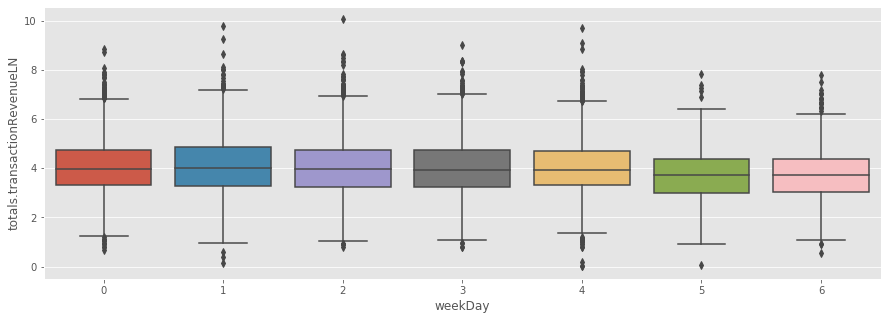

In [65]:
plt.figure(figsize=(15,5))
sns.boxplot(
    x='weekDay', 
    y=LN_TARGET,
    data = df[df['totals.withTransaction'] == 1]
)

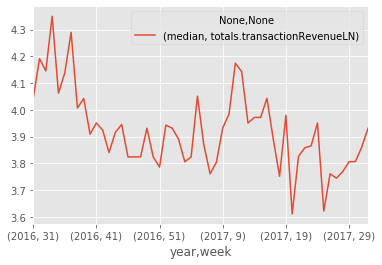

In [66]:
df[df['totals.withTransaction'] == 1].pivot_table(index=['year', 'week'], values=LN_TARGET, aggfunc=[np.median]).plot()

In [67]:
df[df['totals.withTransaction'] == 1].pivot_table(index=['visitHour'], columns=['weekDay'], values=LN_TARGET, aggfunc=[np.median])

median                                                    \
weekDay           0         1         2         3         4         5   
visitHour                                                               
0          3.971612  4.239474  3.824066  3.751619  3.828641  4.110382   
1          3.713328  3.891616  3.969820  3.755837  3.647272  3.752348   
2          4.135726  3.669512  4.042876  3.915291  3.824066  3.831436   
3          3.939444  3.747955  4.004452  3.988439  3.543565  3.796917   
4          3.797140  3.750249  3.824066  3.581016  3.615601  3.610377   
5          3.824066  3.783704  3.446489  3.663305  3.693369  3.842713   
6          3.907412  4.042876  4.127396  3.929863  3.953545  3.486763   
7          3.775499  3.931041  4.083906  3.971423  3.800197  3.446171   
8          3.824066  4.075984  3.824066  3.918332  4.042876  4.333135   
9          3.880384  4.259623  3.365889  3.843555  4.182021  3.896300   
10         3.581294  4.504244  5.232338  3.433342  4.006242  3.821689   
11         3.663049  3.263262  4.067100  3.287769  3.446732  4.027849   
12         3.968214  4.107096  4.834816  3.524320  3.805106  3.760502   
13         3.238694  3.338027  4.097957  3.751619  3.846097  3.950667   
14         3.713084  3.778585  3.609566  4.177307  4.413219  3.996844   
15         4.050011  4.110710  4.097839  4.300618  4.123580  4.412677   
16         3.991758  4.173309  4.142817  4.133641  4.234541  3.736717   
17         4.116192  4.162315  4.042876  4.102874  4.040768  3.255205   
18         4.110710  4.161380  4.110710  3.931826  3.876810  3.176386   
19         3.993141  4.135406  4.042613  3.950354  3.937111  3.760735   
20         4.222151  4.222151  3.838276  3.931826  4.110218  3.781122   
21         4.094163  3.971612  3.944581  3.971612  4.303795  3.824066   
22         3.940950  3.824066  3.896646  3.932218  4.110710  3.614149   
23         4.173899  4.016743  4.021566  4.024637  3.760968  3.583241   

                     
weekDay           6  
visitHour            
0          3.835910  
1          3.352609  
2          3.770229  
3          3.702492  
4          3.792789  
5          3.680819  
6          3.788272  
7          3.581016  
8          3.215254  
9          4.187523  
10         2.889816  
11         3.805122  
12         4.453766  
13         3.227816  
14         3.652215  
15         3.476266  
16         3.939244  
17         4.085182  
18         3.748641  
19         3.554776  
20         3.984530  
21         3.970103  
22         3.332205  
23         3.676047

#### VisitNumber

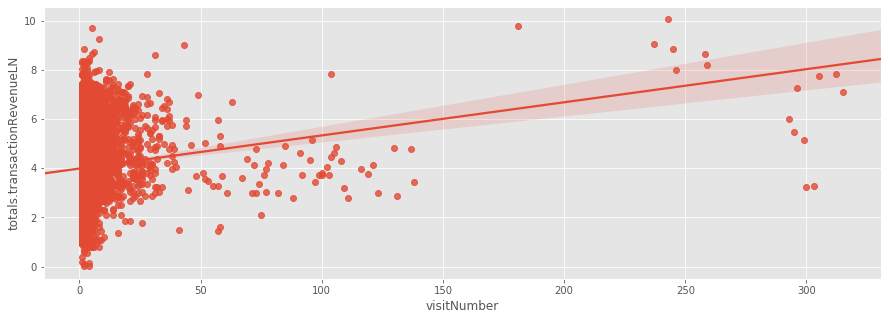

In [68]:
plt.figure(figsize=(15,5))
sns.regplot(
    x = 'visitNumber',
    y = LN_TARGET,
    data = df[df['totals.withTransaction'] == 1]
)

In [69]:
df['visitNumberLN'] = df['visitNumber'].apply(lambda x: np.log1p(x))

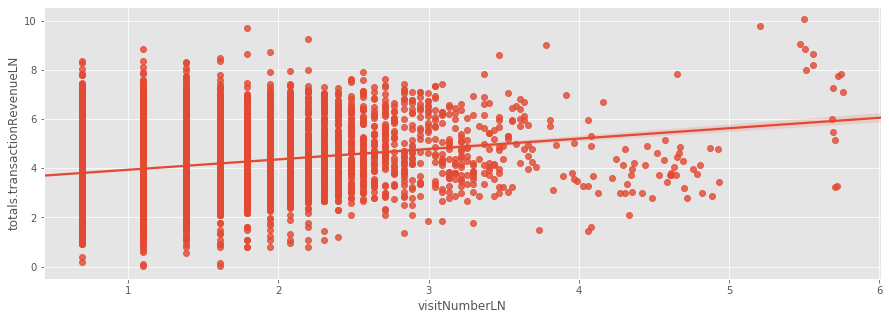

In [70]:
plt.figure(figsize=(15,5))
sns.regplot(
    x = 'visitNumberLN',
    y = LN_TARGET,
    data = df[df['totals.withTransaction'] == 1]
)

#### PageViews

In [71]:
df['totals.pageviews'].head()

fullVisitorId        visitId   
1131660440785968503  1472830385    1
377306020877927890   1472880147    1
3895546263509774583  1472865386    1
4763447161404445595  1472881213    1
27294437909732085    1472822600    1
Name: totals.pageviews, dtype: object

In [72]:
df['totals.pageviews'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '20', '19', '21', '25', '22',
       '26', '23', '24', '30', '27', '29', '28', '32', '31', '34', '33',
       '38', '35', '40', '36', '37', '39', '43', '45', '47', '52', '44',
       '50', '46', '49', '51', '56', '59', '71', '57', '82', '84', '92',
       '90', '41', '79', '138', '48', '69', '112', '42', '65', '60', '63',
       '68', '58', '74', '165', '53', '54', '55', '61', '70', '80', '78',
       '72', '188', '73', '62', '75', '86', '197', '148', '67', '102',
       '64', '103', '144', nan, '81', '119', '104', '128', '87', '111',
       '66', '83', '135', '94', '91', '99', '77', '118', '202', '127',
       '93', '106', '155', '117', '76', '89', '85', '143', '105', '115',
       '95', '110', '137', '120', '116', '208', '126', '400', '101',
       '108', '333', '97', '96', '98', '125', '113', '327', '154', '121',
       '183', '123', '141', '224', '88', '195', '343', '156

In [73]:
df['totals.pageviews'].fillna('0', inplace=True)

In [74]:
df['totals.pageviews'] = df['totals.pageviews'].astype(int)

In [75]:
df['totals.pageviews'].describe()

count    903653.000000
mean          3.849338
std           7.025002
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         469.000000
Name: totals.pageviews, dtype: float64

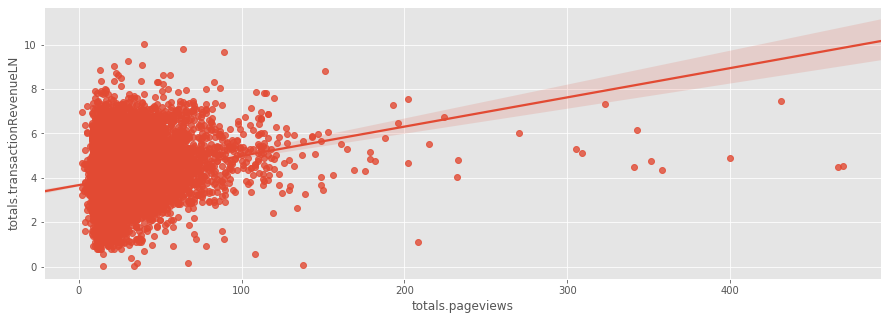

In [76]:
plt.figure(figsize=(15,5))
sns.regplot(
    x = 'totals.pageviews',
    y = LN_TARGET,
    data = df[df['totals.withTransaction'] == 1]
)

In [77]:
df['totals.pageviewsLN'] = df['totals.pageviews'].apply(lambda x: np.log1p(x))

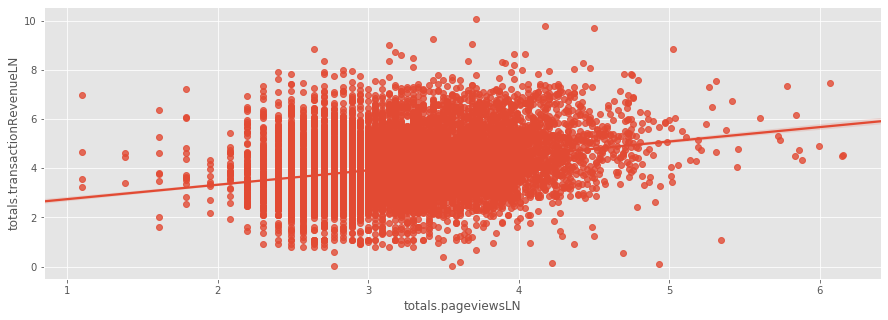

In [78]:
plt.figure(figsize=(15,5))
sns.regplot(
    x = 'totals.pageviewsLN',
    y = LN_TARGET,
    data = df[df['totals.withTransaction'] == 1]
)

### Device

#### deviceBrowser

In [79]:
df['device.browser'].describe()

count     903653
unique        54
top       Chrome
freq      620364
Name: device.browser, dtype: object

In [80]:


# TOP Browsers
print('Porcentaje de uso de navegadores')
print(100 * df['device.browser'].value_counts() / df['device.browser'].count())

Porcentaje de uso de navegadores
Chrome                                         68.650688
Safari                                         20.167586
Firefox                                         4.102128
Internet Explorer                               2.144075
Edge                                            1.129305
Android Webview                                 0.870356
Safari (in-app)                                 0.758034
Opera Mini                                      0.679354
Opera                                           0.624465
UC Browser                                      0.268577
YaBrowser                                       0.231947
Coc Coc                                         0.080451
Amazon Silk                                     0.062081
Android Browser                                 0.061196
Mozilla Compatible Agent                        0.041388
MRCHROME                                        0.029104
Maxthon                                         0.02722

In [81]:
df[df['totals.withTransaction'] == 1].pivot_table(index='device.browser', values=LN_TARGET, aggfunc=np.median)

,totals.transactionRevenueLN
device.browser,
Amazon Silk,3.433665
Android Webview,2.706716
Chrome,3.971423
Edge,3.448913
Firefox,3.710886
Internet Explorer,3.554776
Opera,3.661508
Safari,3.366088
Safari (in-app),2.594560


In [82]:
top_browsers = df['device.browser'].value_counts().head(5)

In [83]:
top_browsers

Chrome               620364
Safari               182245
Firefox               37069
Internet Explorer     19375
Edge                  10205
Name: device.browser, dtype: int64

In [84]:
top_browsers_list = top_browsers.index.to_list()

In [85]:
top_browsers_list

['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge']

In [86]:
top_browsers_list.append('Others')

In [87]:
top_browsers_list

['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge', 'Others']

In [88]:
df['device.browser'] = pd.Categorical(df['device.browser'], categories=top_browsers_list)

In [89]:
df['device.browser'].fillna('Others', inplace=True)

In [90]:
df['device.browser'].value_counts(dropna=False)

Chrome               620364
Safari               182245
Firefox               37069
Others                34395
Internet Explorer     19375
Edge                  10205
Name: device.browser, dtype: int64

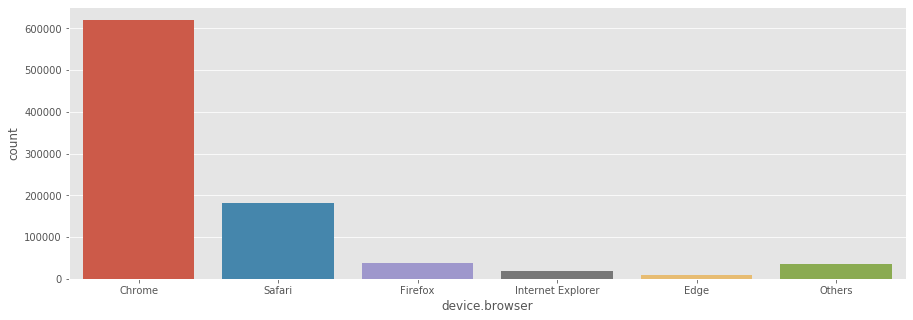

In [91]:
plt.figure(figsize=(15,5))
sns.countplot(
    df['device.browser']
)

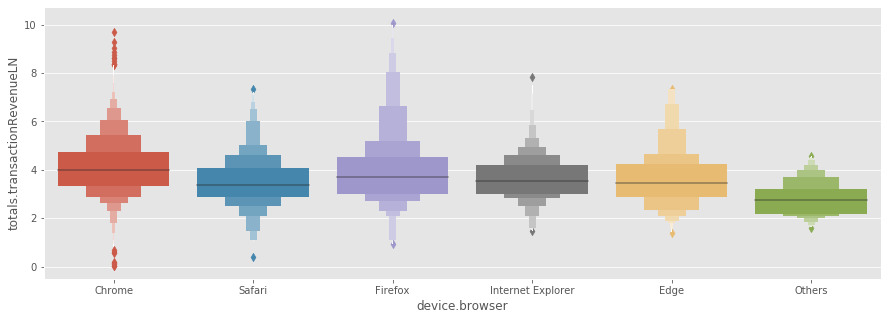

In [92]:
plt.figure(figsize=(15,5))
sns.boxenplot(
    x='device.browser',
    y=LN_TARGET,
    data=df[df['totals.withTransaction']==1]
)

#### Vamos a factorizar todo en una función parar explorar las categóricas

In [93]:
def explore_values(column_name):
    print('Analizando la columna {}'.format(column_name))
    values = df[column_name].value_counts()
    percentages = 100 * df[column_name].value_counts() / df[column_name].count()
    median_values = df[df['totals.withTransaction'] == 1].pivot_table(index=[column_name], values=[LN_TARGET], aggfunc=[np.median])
    
    results_df = pd.concat([values, percentages, median_values], axis=1)
    
    results_df.columns = ['values', 'percentages', 'median']
    
    return results_df.sort_values(by='values', ascending=False)
    

In [94]:
explore_values('device.browser')

Analizando la columna device.browser


,values,percentages,median
Chrome,620364,68.650688,3.971423
Safari,182245,20.167586,3.366088
Firefox,37069,4.102128,3.710886
Others,34395,3.806218,2.769376
Internet Explorer,19375,2.144075,3.554776
Edge,10205,1.129305,3.448913


In [95]:
def set_other(Serie, num_values):
    top_categories = Serie.value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    Serie = pd.Categorical(Serie, categories=top_categories_list).fillna('Others')
    return Serie

In [96]:
def plot_categories(column_name):
    plt.figure(figsize=(15,10))
    
    plt.subplot(2,1,1)
    sns.countplot(
        df[column_name]
        )
    plt.xticks(rotation=45) 
    
    plt.subplot(2,1,2)
    sns.boxenplot(
        x=column_name,
        y=LN_TARGET,
        data=df[df['totals.withTransaction']==1]
        )
    plt.xticks(rotation=45) 
    plt.show()

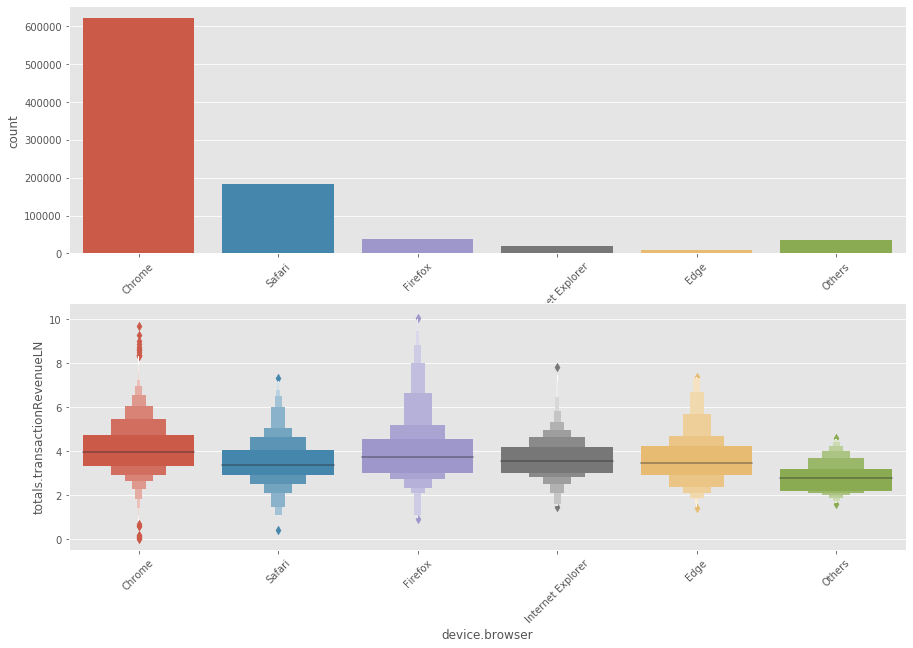

In [97]:
plot_categories('device.browser')

#### Sistema Operativo

In [98]:
explore_values('device.operatingSystem')

Analizando la columna device.operatingSystem


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
Windows,350072,38.739649,3.805328
Macintosh,253938,28.101273,4.042876
Android,123892,13.710130,3.295466
iOS,107665,11.914418,3.257712
Linux,35034,3.876931,3.713328
Chrome OS,26337,2.914504,4.282614
(not set),4695,0.519558,NaN
Windows Phone,1216,0.134565,3.310543
Samsung,280,0.030985,NaN
BlackBerry,218,0.024124,NaN


In [99]:
df['device.operatingSystem'] = set_other(df['device.operatingSystem'], 6)

In [100]:
explore_values('device.operatingSystem')

Analizando la columna device.operatingSystem


,values,percentages,median
Windows,350072,38.739649,3.805328
Macintosh,253938,28.101273,4.042876
Android,123892,13.710130,3.295466
iOS,107665,11.914418,3.257712
Linux,35034,3.876931,3.713328
Chrome OS,26337,2.914504,4.282614
Others,6715,0.743095,3.310543


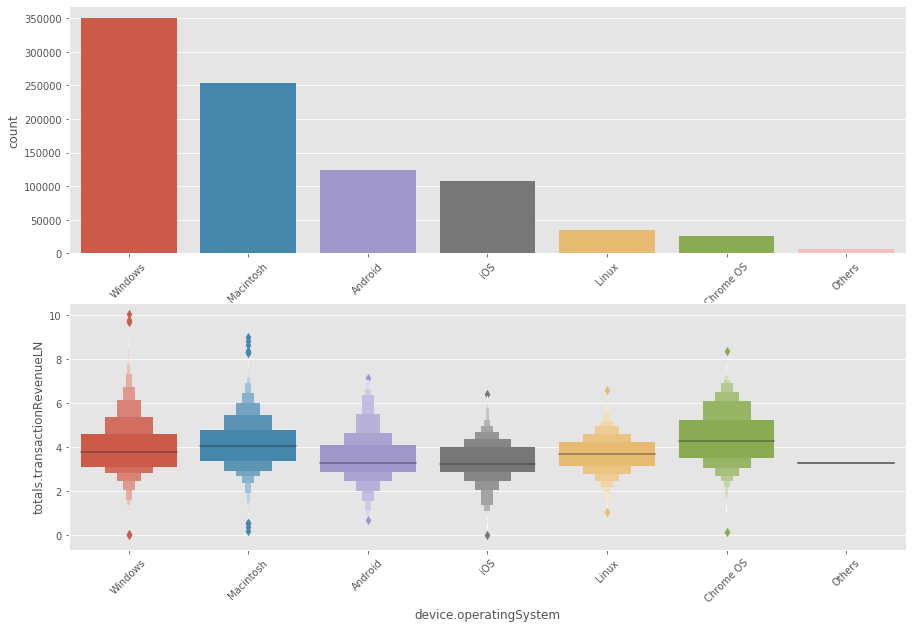

In [101]:
plot_categories('device.operatingSystem')

#### isMobile

In [102]:
explore_values('device.isMobile')

Analizando la columna device.isMobile


,values,percentages,median
device.isMobile,,,
False,664530,73.538183,3.975936
True,239123,26.461817,3.272597


In [103]:
df['device.isMobile'] = df['device.isMobile'].astype(int)

In [104]:
explore_values('device.isMobile')

Analizando la columna device.isMobile


,values,percentages,median
0,664530,73.538183,3.975936
1,239123,26.461817,3.272597


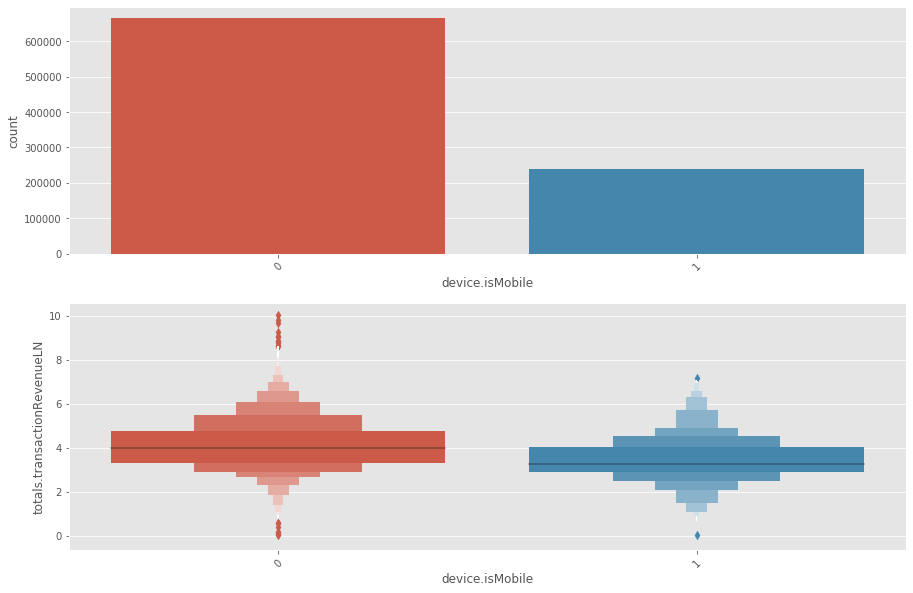

In [105]:
plot_categories('device.isMobile')

#### deviceCategory

In [106]:
explore_values('device.deviceCategory')

Analizando la columna device.deviceCategory


,values,percentages,median
device.deviceCategory,,,
desktop,664479,73.532540,3.975936
mobile,208725,23.097915,3.257712
tablet,30449,3.369546,3.421915


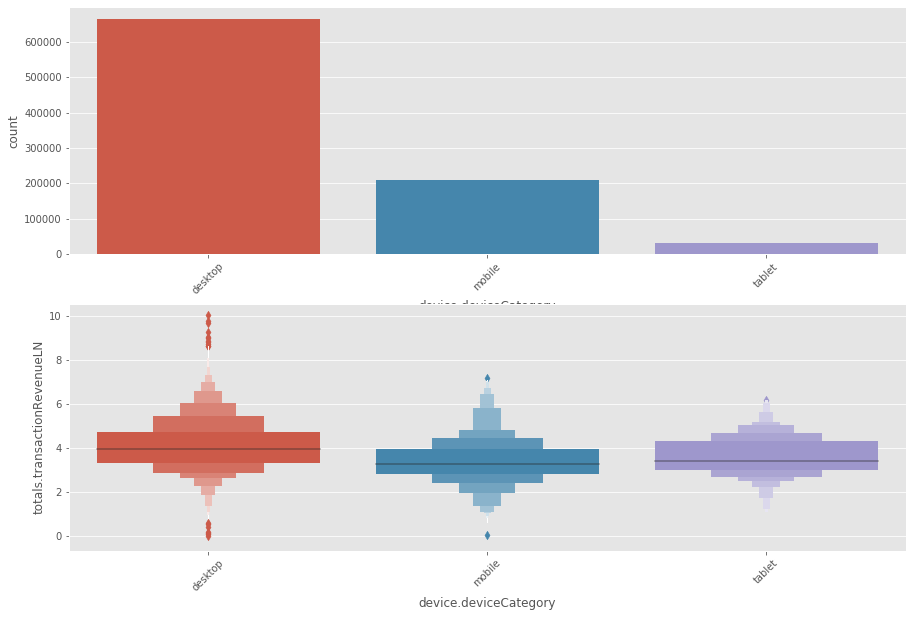

In [107]:
plot_categories('device.deviceCategory')

#### channelGrouping

In [108]:
explore_values('channelGrouping')

Analizando la columna channelGrouping


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
Organic Search,381561,42.224283,3.687754
Social,226117,25.022547,3.543565
Direct,143026,15.827536,4.090504
Referral,104838,11.601577,4.041822
Paid Search,25326,2.802624,3.713328
Affiliates,16403,1.815188,3.090588
Display,6262,0.692965,4.381085
(Other),120,0.013279,2.396986


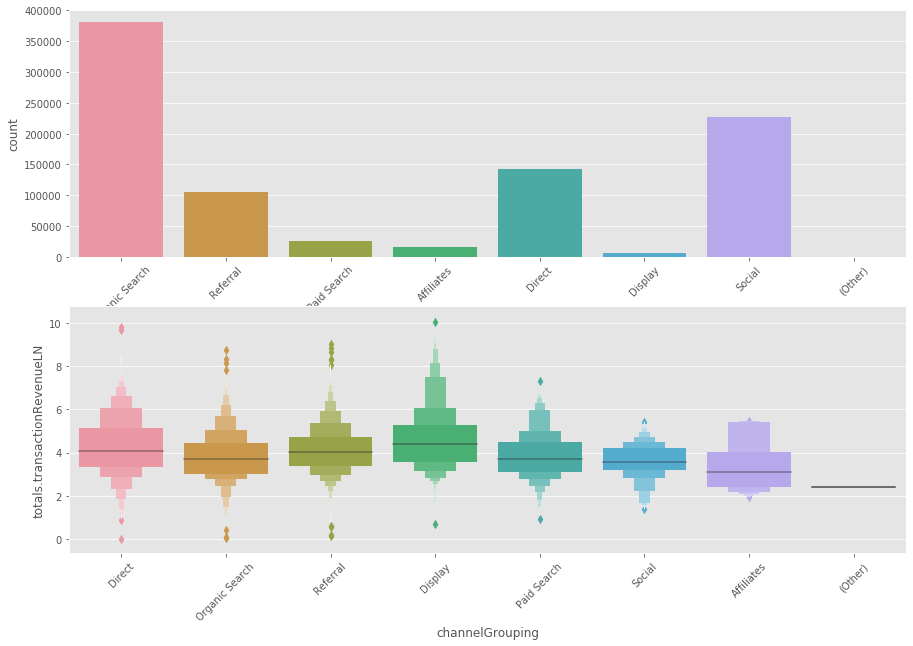

In [109]:
plot_categories('channelGrouping')

#### Continent

In [110]:
explore_values('geoNetwork.continent')

Analizando la columna geoNetwork.continent


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
Americas,450377,49.839596,3.920190
Asia,223698,24.754856,4.042525
Europe,198311,21.945481,3.683616
Oceania,15054,1.665905,4.180508
Africa,14745,1.631710,7.345472
(not set),1468,0.162452,4.878631


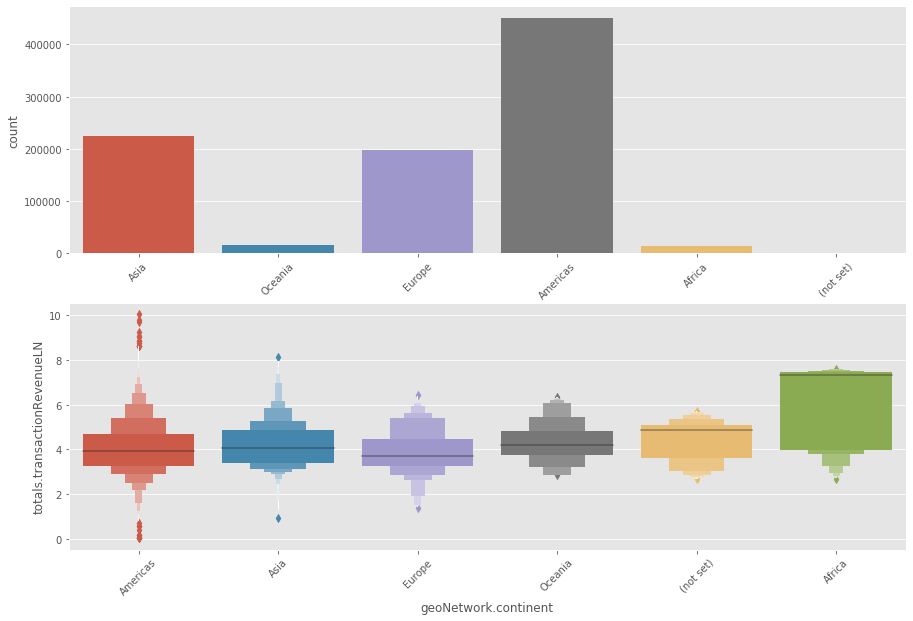

In [111]:
plot_categories('geoNetwork.continent')

#### Subcontinent

In [112]:
explore_values('geoNetwork.subContinent')

Analizando la columna geoNetwork.subContinent


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
Northern America,390657,43.230864,3.907613
Southeast Asia,77800,8.609499,4.690413
Southern Asia,59321,6.564577,3.495901
Western Europe,59114,6.541670,3.987351
Northern Europe,58168,6.436984,3.543565
Eastern Asia,46919,5.192148,3.883006
Eastern Europe,45249,5.007342,3.527256
South America,41731,4.618034,4.630643
Western Asia,38443,4.254177,4.110710
Southern Europe,35780,3.959484,4.618868


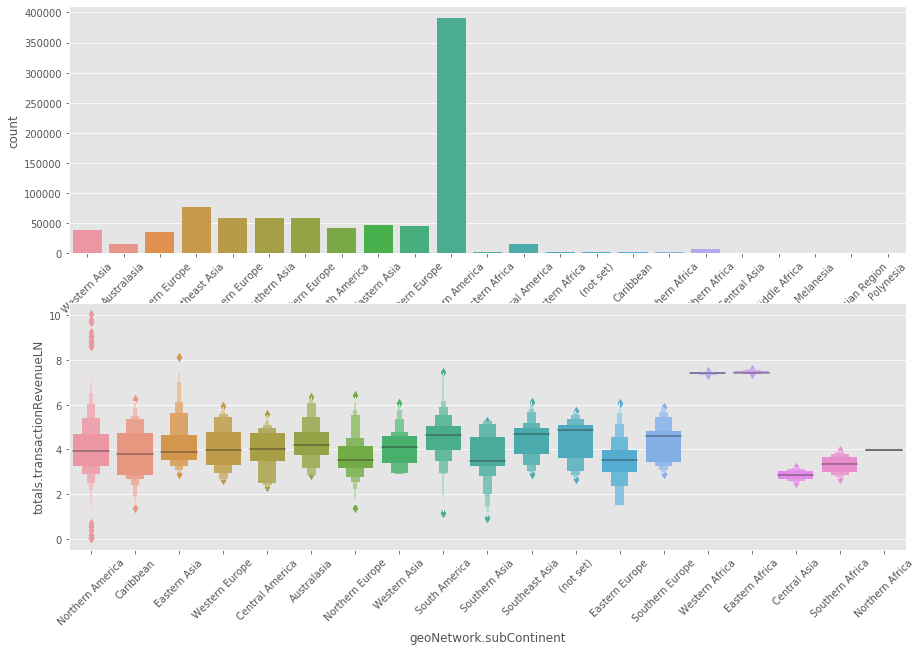

In [113]:
plot_categories('geoNetwork.subContinent')

#### Country

In [114]:
explore_values('geoNetwork.country')

Analizando la columna geoNetwork.country


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
United States,364744,40.363281,3.907613
India,51140,5.659252,3.442007
United Kingdom,37393,4.137982,3.801431
Canada,25869,2.862714,3.894567
Vietnam,24598,2.722063,NaN
Turkey,20522,2.271004,3.684686
Thailand,20123,2.226850,4.718142
Germany,19980,2.211026,3.852962
Brazil,19783,2.189225,3.668153
Japan,19731,2.183471,3.848870


In [115]:
df['geoNetwork.country'] = set_other(df['geoNetwork.country'], 50)

In [116]:
explore_values('geoNetwork.country')

Analizando la columna geoNetwork.country


,values,percentages,median
United States,364744,40.363281,3.907613
India,51140,5.659252,3.442007
Others,49426,5.469577,4.051401
United Kingdom,37393,4.137982,3.801431
Canada,25869,2.862714,3.894567
Vietnam,24598,2.722063,NaN
Turkey,20522,2.271004,3.684686
Thailand,20123,2.226850,4.718142
Germany,19980,2.211026,3.852962
Brazil,19783,2.189225,3.668153


#### City

In [117]:
df['geoNetwork.city'].describe()

count                            903653
unique                              649
top       not available in demo dataset
freq                             508229
Name: geoNetwork.city, dtype: object

In [118]:
cities = pd.read_excel('/Users/juan/Downloads/global-city-population-estimates.xls')

In [119]:
cities.head()

,Country Code,Country or area,City Code,Urban Agglomeration,2020
0,392,Japan,21671,Tokyo,38323.229
1,356,India,21228,Delhi,29347.622
2,156,China,20656,Shanghai,27137.316
3,76,Brazil,20287,São Paulo,22118.900
4,356,India,21206,Mumbai (Bombay),22838.483


In [120]:
cities[cities['Urban Agglomeration'] == 'Barcelona']

,Country Code,Country or area,City Code,Urban Agglomeration,2020
69,724,Spain,22525,Barcelona,5478.238


In [121]:
cities = cities[['Urban Agglomeration', '2020']]

In [122]:
cities.set_index('Urban Agglomeration', inplace=True)

In [123]:
cities.sort_values(by='2020', ascending=False)

,2020
Urban Agglomeration,
Tokyo,38323.229
Delhi,29347.622
Shanghai,27137.316
Beijing,24201.465
Mumbai (Bombay),22838.483
...,...
Aguadilla-Isabela-San Sebastian,301.944
Vladikavkaz,301.493
Katowice,300.059


In [124]:
cities.columns = ['Population']

In [125]:
cities['Population'] = cities['Population'].astype(float)

In [126]:
cities.describe()

,Population
count,1682.000000
mean,1469.925011
std,2711.518955
min,293.465000
25%,451.050250
50%,673.567500
75%,1258.040000
max,38323.229000


In [127]:
cities.sort_values(by='Population', ascending=False).head()

,Population
Urban Agglomeration,
Tokyo,38323.229
Delhi,29347.622
Shanghai,27137.316
Beijing,24201.465
Mumbai (Bombay),22838.483


In [128]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 903653 entries, (1131660440785968503, 1472830385) to (0814900163617805053, 1483574474)
Columns: 38 entries, channelGrouping to totals.pageviewsLN
dtypes: category(3), float64(5), int64(12), object(18)
memory usage: 283.0+ MB


In [129]:
df = df.join(cities, how='left', on='geoNetwork.city')

In [130]:
df['Population'].fillna(0, inplace=True)

In [131]:
df['geoNetwork.city'] = set_other(df['geoNetwork.city'], 50)

In [132]:
features_to_delete = ['geoNetwork.region','geoNetwork.metro','geoNetwork.city','geoNetwork.networkDomain']
df.drop(features_to_delete, axis=1, inplace=True)

#### Campaign

In [133]:
explore_values('trafficSource.campaign')

Analizando la columna trafficSource.campaign


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
(not set),865347,95.760983,3.931041
Data Share Promo,16403,1.815188,3.090588
AW - Dynamic Search Ads Whole Site,14244,1.576269,3.710396
AW - Accessories,7070,0.782380,3.700854
test-liyuhz,392,0.043379,3.761200
AW - Electronics,96,0.010624,NaN
Retail (DO NOT EDIT owners nophakun and tianyu),50,0.005533,3.175968
AW - Apparel,46,0.005090,4.367167
All Products,4,0.000443,NaN
Data Share,1,0.000111,NaN


In [134]:
df['trafficSource.campaign'] = set_other(df['trafficSource.campaign'], 4)

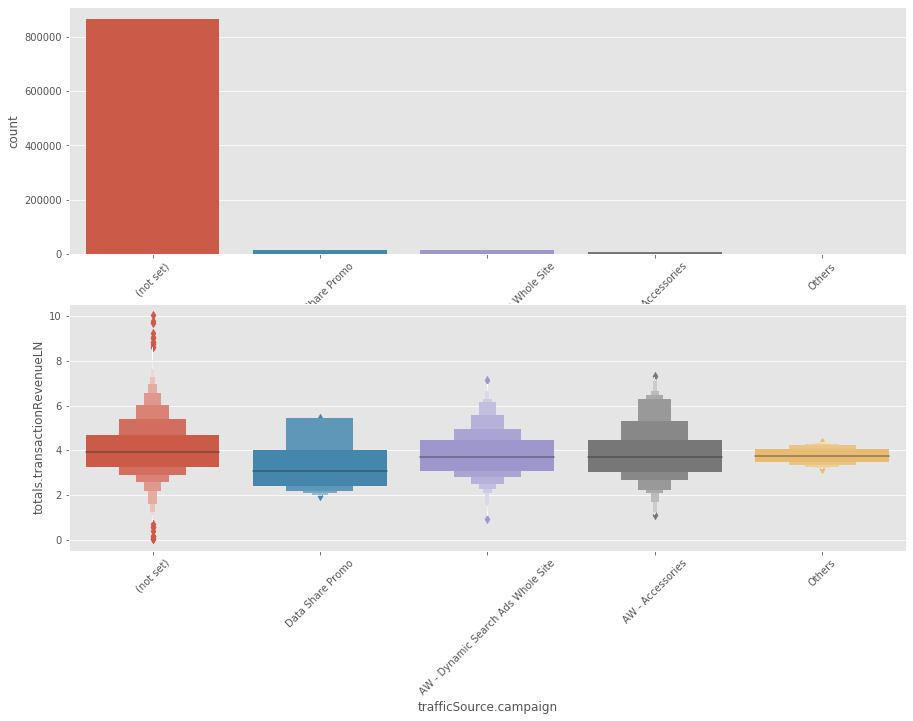

In [135]:
plot_categories('trafficSource.campaign')

#### Source

In [136]:
explore_values('trafficSource.source')

Analizando la columna trafficSource.source


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
google,400788,44.351980,3.688379
youtube.com,212602,23.526951,2.889816
(direct),143028,15.827757,4.090504
mall.googleplex.com,66416,7.349724,4.033001
Partners,16411,1.816073,3.090588
analytics.google.com,16172,1.789625,NaN
dfa,5686,0.629224,4.506233
google.com,4669,0.516681,3.442979
m.facebook.com,3365,0.372377,3.044874
baidu,3356,0.371381,NaN


In [137]:
df['trafficSource.source'] = set_other(df['trafficSource.source'], 5)

In [138]:
explore_values('trafficSource.source')

Analizando la columna trafficSource.source


,values,percentages,median
google,400788,44.351980,3.688379
youtube.com,212602,23.526951,2.889816
(direct),143028,15.827757,4.090504
mall.googleplex.com,66416,7.349724,4.033001
Others,64408,7.127515,4.042349
Partners,16411,1.816073,3.090588


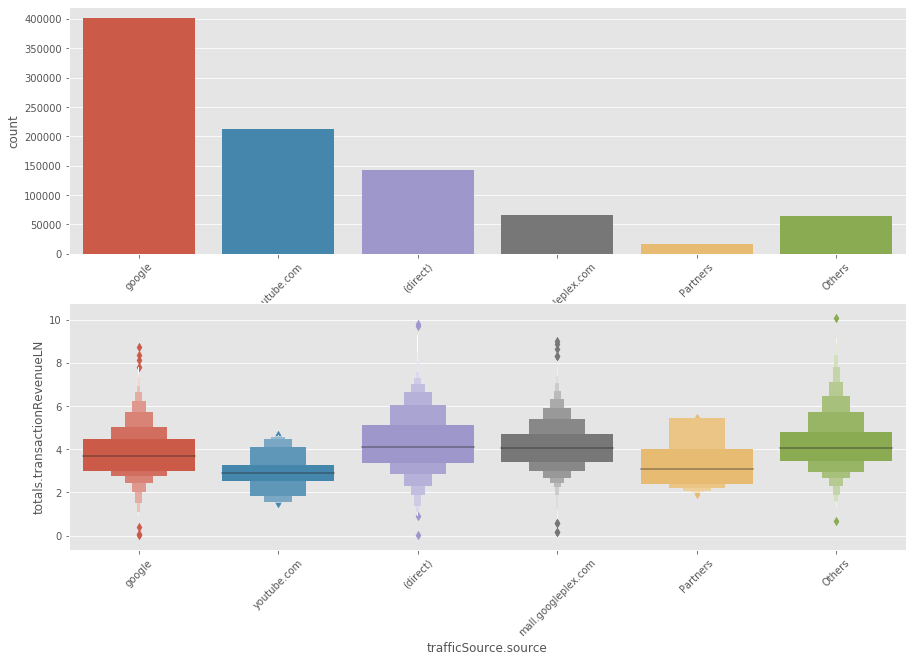

In [139]:
plot_categories('trafficSource.source')

#### Medium


In [140]:
explore_values('trafficSource.medium')

Analizando la columna trafficSource.medium


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
organic,381561,42.224283,3.687754
referral,330955,36.624125,4.029095
(none),143026,15.827536,4.090504
cpc,25326,2.802624,3.713328
affiliate,16403,1.815188,3.090588
cpm,6262,0.692965,4.381085
(not set),120,0.013279,2.396986


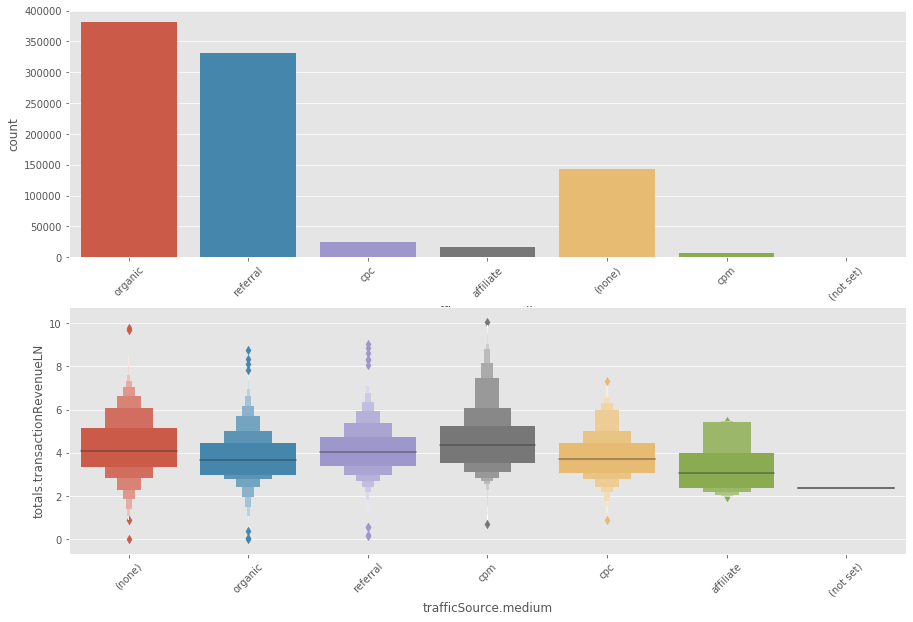

In [141]:
plot_categories('trafficSource.medium')

#### Keyword

In [142]:
explore_values('trafficSource.keyword').head(100)

Analizando la columna trafficSource.keyword


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
(not provided),366363,91.425270,3.688129
6qEhsCssdK0z36ri,11503,2.870554,3.713328
(Remarketing/Content targeting),2298,0.573462,3.761200
1hZbAqLCbjwfgOH7,2264,0.564977,3.574398
google merchandise store,2209,0.551252,3.780775
Google Merchandise,1648,0.411256,3.736955
google store,1277,0.318673,1.601406
youtube,568,0.141743,NaN
(User vertical targeting),489,0.122029,NaN
1X4Me6ZKNV0zg-jV,467,0.116539,3.672447


In [143]:
df['trafficSource.keyword'].fillna('Without KW', inplace=True)

In [144]:
df['KeywordYoutube'] = df['trafficSource.keyword'].str.contains('youtube', case=False).astype(int)

In [145]:
explore_values('KeywordYoutube')

Analizando la columna KeywordYoutube


,values,percentages,median
0,900749,99.678638,3.921775
1,2904,0.321362,2.942859


In [146]:
df.drop('trafficSource.keyword', axis=1, inplace=True)

#### ReferralPath

In [147]:
explore_values('trafficSource.referralPath').head(50)

Analizando la columna trafficSource.referralPath


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
/,75523,22.820684,4.030695
/yt/about/,71036,21.464853,2.989974
/analytics/web/,14620,4.417706,NaN
/yt/about/tr/,14599,4.411360,NaN
/yt/about/vi/,13753,4.155726,NaN
/yt/about/es-419/,12735,3.848118,NaN
/yt/about/pt-BR/,12003,3.626930,NaN
/yt/about/th/,11430,3.453788,NaN
/yt/about/ru/,11193,3.382174,NaN
/yt/about/es/,7092,2.142980,NaN


In [148]:
df['referralHome'] = (df['trafficSource.referralPath'] == '/').astype(int)

In [149]:
explore_values('referralHome')

Analizando la columna referralHome


,values,percentages,median
0,828130,91.642478,3.812865
1,75523,8.357522,4.030695


In [150]:
df.drop('trafficSource.referralPath', axis=1, inplace=True)

#### page

In [151]:
explore_values('trafficSource.adwordsClickInfo.page')

Analizando la columna trafficSource.adwordsClickInfo.page


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
1,21362,99.543336,3.71174
2,73,0.340168,NaN
3,10,0.046598,NaN
5,7,0.032619,NaN
7,3,0.013979,NaN
4,2,0.009320,NaN
9,2,0.009320,NaN
14,1,0.004660,NaN


In [152]:
df.drop('trafficSource.adwordsClickInfo.page', axis=1, inplace=True)

#### Slot

In [153]:
explore_values('trafficSource.adwordsClickInfo.slot')

Analizando la columna trafficSource.adwordsClickInfo.slot


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
Top,20956,97.651445,3.713084
RHS,504,2.348555,3.294354


In [154]:
df.drop('trafficSource.adwordsClickInfo.slot', axis=1, inplace=True)

In [155]:
df.drop('trafficSource.adwordsClickInfo.gclId', axis=1, inplace=True)

#### AdContent

In [156]:
explore_values('trafficSource.adContent')

Analizando la columna trafficSource.adContent


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
Google Merchandise Collection,5122,46.793349,3.756772
Google Online Store,1245,11.374018,3.237678
Display Ad created 3/11/14,967,8.834277,4.676188
Full auto ad IMAGE ONLY,822,7.509593,3.760735
Ad from 12/13/16,610,5.572812,NaN
Ad from 11/3/16,489,4.467385,NaN
Display Ad created 3/11/15,392,3.581217,3.761200
{KeyWord:Google Brand Items},251,2.293075,NaN
{KeyWord:Google Merchandise},155,1.416042,NaN
Ad from 11/7/16,123,1.123698,NaN


In [157]:
df['trafficSource.adContent'] = set_other(df['trafficSource.adContent'], 3)

In [158]:
explore_values('trafficSource.adwordsClickInfo.adNetworkType')

Analizando la columna trafficSource.adwordsClickInfo.adNetworkType


/Users/juan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,values,percentages,median
Google Search,21453,99.967381,3.71174
Search partners,7,0.032619,NaN


In [159]:
df.drop('trafficSource.adwordsClickInfo.adNetworkType', axis=1, inplace=True)

#### Final Dataset

In [160]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 903653 entries, (1131660440785968503, 1472830385) to (0814900163617805053, 1483574474)
Data columns (total 31 columns):
channelGrouping                903653 non-null object
visitNumber                    903653 non-null int64
device.browser                 903653 non-null category
device.operatingSystem         903653 non-null category
device.isMobile                903653 non-null int64
device.deviceCategory          903653 non-null object
geoNetwork.continent           903653 non-null object
geoNetwork.subContinent        903653 non-null object
geoNetwork.country             903653 non-null category
totals.hits                    903653 non-null int64
totals.pageviews               903653 non-null int64
totals.transactionRevenue      903653 non-null float64
trafficSource.campaign         903653 non-null category
trafficSource.source           903653 non-null category
trafficSource.medium           903653 non-null object
trafficSource

In [161]:
df.describe(exclude=np.number).T

,count,unique,top,freq
channelGrouping,903653,8,Organic Search,381561
device.browser,903653,6,Chrome,620364
device.operatingSystem,903653,7,Windows,350072
device.deviceCategory,903653,3,desktop,664479
geoNetwork.continent,903653,6,Americas,450377
geoNetwork.subContinent,903653,23,Northern America,390657
geoNetwork.country,903653,51,United States,364744
trafficSource.campaign,903653,5,(not set),865347
trafficSource.source,903653,6,google,400788
trafficSource.medium,903653,7,organic,381561


In [162]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
visitNumber,903653.0,2.264897,9.283735,1.000000,1.000000,1.000000,1.000000,395.000000
device.isMobile,903653.0,0.264618,0.441130,0.000000,0.000000,0.000000,1.000000,1.000000
totals.hits,903653.0,4.596538,9.641437,1.000000,1.000000,2.000000,4.000000,500.000000
totals.pageviews,903653.0,3.849338,7.025002,0.000000,1.000000,1.000000,4.000000,469.000000
totals.transactionRevenue,903653.0,1.704273,52.778659,0.000000,0.000000,0.000000,0.000000,23129.500000
totals.withTransaction,903653.0,0.012743,0.112162,0.000000,0.000000,0.000000,0.000000,1.000000
totals.transactionRevenueLN,903653.0,0.051507,0.471994,0.000000,0.000000,0.000000,0.000000,10.048907
totals.hitsLN,903653.0,1.265608,0.785061,0.693147,0.693147,1.098612,1.609438,6.216606
year,903653.0,2016.517079,0.499708,2016.000000,2016.000000,2017.000000,2017.000000,2017.000000
month,903653.0,6.987671,3.484576,1.000000,4.000000,7.000000,10.000000,12.000000


### One Hot Encoding on categorical columns

In [163]:
def generate_dummies(dataframe, variable_name):
    _dummy_dataset = pd.get_dummies(dataframe[variable_name], prefix=variable_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    dataframe.drop(variable_name, axis=1, inplace=True)
    return dataframe

In [164]:
for column in df.select_dtypes(exclude=np.number).columns:
    df = generate_dummies(df, column)

In [165]:
# df.describe(exclude=np.number).T

In [166]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
visitNumber,903653.0,2.264897,9.283735,1.000000,1.000000,1.000000,1.000000,395.000000
device.isMobile,903653.0,0.264618,0.441130,0.000000,0.000000,0.000000,1.000000,1.000000
totals.hits,903653.0,4.596538,9.641437,1.000000,1.000000,2.000000,4.000000,500.000000
totals.pageviews,903653.0,3.849338,7.025002,0.000000,1.000000,1.000000,4.000000,469.000000
totals.transactionRevenue,903653.0,1.704273,52.778659,0.000000,0.000000,0.000000,0.000000,23129.500000
totals.withTransaction,903653.0,0.012743,0.112162,0.000000,0.000000,0.000000,0.000000,1.000000
totals.transactionRevenueLN,903653.0,0.051507,0.471994,0.000000,0.000000,0.000000,0.000000,10.048907
totals.hitsLN,903653.0,1.265608,0.785061,0.693147,0.693147,1.098612,1.609438,6.216606
year,903653.0,2016.517079,0.499708,2016.000000,2016.000000,2017.000000,2017.000000,2017.000000
month,903653.0,6.987671,3.484576,1.000000,4.000000,7.000000,10.000000,12.000000


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 903653 entries, (1131660440785968503, 1472830385) to (0814900163617805053, 1483574474)
Columns: 146 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(6), int64(14), uint8(126)
memory usage: 285.6+ MB


## Modelling

In [168]:
target_correlated_features = ['totals.transactionRevenue', 'totals.withTransaction']

In [169]:
df.drop(target_correlated_features, inplace=True, axis=1)

In [170]:
df.pivot_table(index=['year', 'month'], values=['totals.transactionRevenueLN'], aggfunc=[len, np.mean])

len                        mean
           totals.transactionRevenueLN totals.transactionRevenueLN
year month                                                        
2016 8                         74759.0                    0.063340
     9                         71032.0                    0.050346
     10                        97506.0                    0.036364
     11                       113972.0                    0.032605
     12                        79124.0                    0.069343
2017 1                         64694.0                    0.043581
     2                         62192.0                    0.045995
     3                         69931.0                    0.051932
     4                         67126.0                    0.056208
     5                         65371.0                    0.067822
     6                         63578.0                    0.058921
     7                         71812.0                    0.056305
     8                          2556.0                    0.069312

In [171]:
df_val = df[(df['year'] * 100 + df['month']) >= 201706]
df_dev = df[(df['year'] * 100 + df['month']) <= 201705]

In [172]:
df_val.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 137946 entries, (6136444193474843946, 1498250158) to (9462137157747451347, 1499626657)
Columns: 144 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(5), int64(13), uint8(126)
memory usage: 48.8+ MB


In [173]:
df_dev.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 765707 entries, (1131660440785968503, 1472830385) to (0814900163617805053, 1483574474)
Columns: 144 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(5), int64(13), uint8(126)
memory usage: 215.2+ MB


In [174]:
TARGET = ['totals.transactionRevenueLN']

In [175]:
df_val_X = df_val.drop(TARGET, axis=1)
df_val_y = df_val[TARGET]
df_dev_X = df_dev.drop(TARGET, axis=1)
df_dev_y = df_dev[TARGET]

### Random Holdout

In [176]:
X_train, X_test, y_train, y_test = train_test_split(df_dev_X, df_dev_y, test_size=0.3, random_state=42)

In [177]:
X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 535994 entries, (1765276545258127891, 1479174232) to (746742425101517807, 1491864370)
Columns: 143 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(4), int64(13), uint8(126)
memory usage: 150.2+ MB


In [178]:
X_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 229713 entries, (0642097395211836089, 1484090021) to (9538692262841832506, 1474342844)
Columns: 143 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(4), int64(13), uint8(126)
memory usage: 71.4+ MB


### LightGBM en RH

In [179]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test  = lgb.Dataset(X_test, label=y_test)

In [180]:
params = {
        'objective' : 'regression',
        'metric' : 'mse',  
        'learning_rate' : 0.1,
        'bagging_fraction' : 0.7,
        'feature_fraction' : 0.5,
        'max_depth': 5
}

In [181]:
%%time 
model = lgb.train(params, lgb_train, 1000, valid_sets=[lgb_test], early_stopping_rounds=5, verbose_eval=100)

Training until validation scores don't improve for 5 rounds
[100]	valid_0's l2: 0.144057
Early stopping, best iteration is:
[148]	valid_0's l2: 0.143205
CPU times: user 28.2 s, sys: 1.83 s, total: 30.1 s
Wall time: 5.77 s


In [182]:
test_prediction = pd.DataFrame(model.predict(X_test), columns=['Prediction'], index=X_test.index)

In [183]:
test_prediction.sort_values(by='Prediction')

,,Prediction
fullVisitorId,visitId,
2760718681608273123,1493776936,-1.006054
5311253006486037295,1470159345,-0.921035
9057185829926960838,1472701503,-0.833883
5595134049603009695,1484095506,-0.731606
2477246048701063311,1493778263,-0.613208
...,...,...
5017352267517896224,1477330337,4.949592
7344519175727343086,1472240181,5.097568
7638336411447332495,1485447665,5.232229


In [184]:
results_df = y_test.join(test_prediction)

In [185]:
results_df.head(20)

,,totals.transactionRevenueLN,Prediction
fullVisitorId,visitId,,
0000027376579751715,1486866293,0.0,-0.001031
0000040862739425590,1486838824,0.0,0.004521
0000245437374675368,1472862842,0.0,-0.001318
0000253133284033056,1470755846,0.0,-0.000894
0000291342601222013,1491064213,0.0,0.002535
000033471059618621,1480289088,0.0,-0.000318
0000393882583300244,1471737641,0.0,-0.001045
0000419982866146379,1475338058,0.0,0.000783
0000426241577666985,1479449976,0.0,-0.000347


In [186]:
results_df.sort_values(by='totals.transactionRevenueLN', ascending=False).head(20)

totals.transactionRevenueLN  Prediction
fullVisitorId       visitId                                            
1957458976293878100 1491423580                    10.048907    0.858885
                    1491578402                     8.828781    1.448450
                    1492527922                     8.633275    2.420691
2969957690756250633 1490305208                     8.342721    1.091750
9817395183603701442 1472145168                     8.315444    3.207472
6226617329849661943 1492779203                     7.966049    2.975475
2517364798811740879 1477009448                     7.913539    0.315629
5590743844926892757 1482162240                     7.839715    0.698809
1044832976156649069 1474931750                     7.783516    1.524422
1410336440849356236 1479365088                     7.598900    3.624748
9662800125044386280 1477058512                     7.589589    1.603157
20772809165725592   1476822980                     7.556428    1.427820
3924372865099736100 1472132217                     7.451201    4.526511
7113011772090059658 1495083738                     7.442393    1.432189
2496439703637913793 1482283481                     7.427019    2.775624
3751433429956400495 1477299810                     7.426966    0.184423
1956307607572137989 1479742819                     7.361534    0.131575
7117209037706583763 1485564412                     7.336553    1.764429
1070774421633587976 1473804398                     7.320361    1.893220
9264804092676520813 1472146923                     7.295972    2.416398

In [187]:
feature_importances = pd.DataFrame(model.feature_importance(), columns=['Importance'], index=[X_test.columns])
feature_importances.sort_values(by='Importance', ascending=False).head(10)

,Importance
totals.hits,443
totals.pageviews,423
visitNumber,309
week,265
totals.pageviewsLN,260
visitHour,221
totals.hitsLN,214
visitNumberLN,149
day,139
geoNetwork.country_United States,129


### XGBoost

In [188]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbose=True)

In [189]:
%%time
model.fit(X_train, y_train)

CPU times: user 5min 55s, sys: 4.6 s, total: 6min
Wall time: 6min 4s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbose=True, verbosity=1)

In [190]:
test_prediction = pd.DataFrame(model.predict(X_test), columns=['Prediction'], index=X_test.index)

In [191]:
test_prediction.sort_values(by='Prediction')

,,Prediction
fullVisitorId,visitId,
3000212461242439183,1473322918,-0.878582
8748733332941588759,1490478252,-0.693095
0558295188445549813,1474031631,-0.670340
9751687059892672069,1478964185,-0.638752
8920002702117390855,1476192648,-0.632999
...,...,...
5017352267517896224,1477330337,3.736296
7561014297963838461,1488821175,3.773552
2048511066419559359,1488917517,3.781237


In [192]:
results_df = y_test.join(test_prediction)

In [193]:
results_df.head(20)

,,totals.transactionRevenueLN,Prediction
fullVisitorId,visitId,,
0000027376579751715,1486866293,0.0,-0.000664
0000040862739425590,1486838824,0.0,0.001076
0000245437374675368,1472862842,0.0,-0.001317
0000253133284033056,1470755846,0.0,-0.000772
0000291342601222013,1491064213,0.0,-0.000436
000033471059618621,1480289088,0.0,-0.001000
0000393882583300244,1471737641,0.0,-0.001368
0000419982866146379,1475338058,0.0,-0.000419
0000426241577666985,1479449976,0.0,-0.001000


In [194]:
results_df.sort_values(by='totals.transactionRevenueLN', ascending=False).head(20)

totals.transactionRevenueLN  Prediction
fullVisitorId       visitId                                            
1957458976293878100 1491423580                    10.048907    1.454192
                    1491578402                     8.828781    1.478332
                    1492527922                     8.633275    1.631820
2969957690756250633 1490305208                     8.342721    0.890054
9817395183603701442 1472145168                     8.315444    2.868312
6226617329849661943 1492779203                     7.966049    2.725664
2517364798811740879 1477009448                     7.913539    0.254919
5590743844926892757 1482162240                     7.839715    0.859061
1044832976156649069 1474931750                     7.783516    1.157131
1410336440849356236 1479365088                     7.598900    3.232300
9662800125044386280 1477058512                     7.589589    1.672257
20772809165725592   1476822980                     7.556428    1.350677
3924372865099736100 1472132217                     7.451201    3.596053
7113011772090059658 1495083738                     7.442393    1.648246
2496439703637913793 1482283481                     7.427019    2.214373
3751433429956400495 1477299810                     7.426966    0.233226
1956307607572137989 1479742819                     7.361534    0.154608
7117209037706583763 1485564412                     7.336553    1.868652
1070774421633587976 1473804398                     7.320361    1.838428
9264804092676520813 1472146923                     7.295972    1.987679

In [195]:
results_df['squared_error'] = (results_df['totals.transactionRevenueLN'] - results_df['Prediction'])**2
results_df['rooted_squared_error'] = np.sqrt(results_df['squared_error'])

In [196]:
results_df.sort_values(by='totals.transactionRevenueLN', ascending=False).head(20)

totals.transactionRevenueLN  Prediction  \
fullVisitorId       visitId                                               
1957458976293878100 1491423580                    10.048907    1.454192   
                    1491578402                     8.828781    1.478332   
                    1492527922                     8.633275    1.631820   
2969957690756250633 1490305208                     8.342721    0.890054   
9817395183603701442 1472145168                     8.315444    2.868312   
6226617329849661943 1492779203                     7.966049    2.725664   
2517364798811740879 1477009448                     7.913539    0.254919   
5590743844926892757 1482162240                     7.839715    0.859061   
1044832976156649069 1474931750                     7.783516    1.157131   
1410336440849356236 1479365088                     7.598900    3.232300   
9662800125044386280 1477058512                     7.589589    1.672257   
20772809165725592   1476822980                     7.556428    1.350677   
3924372865099736100 1472132217                     7.451201    3.596053   
7113011772090059658 1495083738                     7.442393    1.648246   
2496439703637913793 1482283481                     7.427019    2.214373   
3751433429956400495 1477299810                     7.426966    0.233226   
1956307607572137989 1479742819                     7.361534    0.154608   
7117209037706583763 1485564412                     7.336553    1.868652   
1070774421633587976 1473804398                     7.320361    1.838428   
9264804092676520813 1472146923                     7.295972    1.987679   

                                squared_error  rooted_squared_error  
fullVisitorId       visitId                                          
1957458976293878100 1491423580      73.869138              8.594716  
                    1491578402      54.029107              7.350449  
                    1492527922      49.020376              7.001455  
2969957690756250633 1490305208      55.542242              7.452667  
9817395183603701442 1472145168      29.671247              5.447132  
6226617329849661943 1492779203      27.461633              5.240385  
2517364798811740879 1477009448      58.654460              7.658620  
5590743844926892757 1482162240      48.729524              6.980654  
1044832976156649069 1474931750      43.908977              6.626385  
1410336440849356236 1479365088      19.067199              4.366600  
9662800125044386280 1477058512      35.014812              5.917332  
20772809165725592   1476822980      38.511345              6.205751  
3924372865099736100 1472132217      14.862164              3.855148  
7113011772090059658 1495083738      33.572140              5.794147  
2496439703637913793 1482283481      27.171679              5.212646  
3751433429956400495 1477299810      51.749895              7.193740  
1956307607572137989 1479742819      51.939786              7.206926  
7117209037706583763 1485564412      29.897937              5.467901  
1070774421633587976 1473804398      30.051595              5.481933  
9264804092676520813 1472146923      28.177978              5.308293

In [197]:
mse = results_df['squared_error'].mean()
rmse = results_df['rooted_squared_error'].mean()

In [198]:
rmse

0.07190648598683827

In [199]:
mae = rmse / y_test['totals.transactionRevenueLN'].mean()

In [200]:
mae

1.4472543658178043

In [201]:
results_df['totals.withTransaction'] = (results_df['totals.transactionRevenueLN'] > 0)

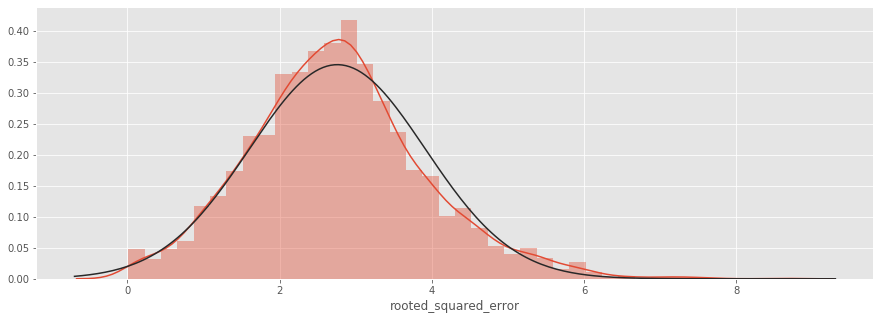

In [202]:
plt.figure(figsize=(15,5))
sns.distplot(
    results_df[results_df['totals.withTransaction'] == 1]['rooted_squared_error'],
    bins=40,
    fit=stats.norm
)

In [203]:
results_df[results_df['totals.withTransaction'] == 1].describe()

,totals.transactionRevenueLN,Prediction,squared_error,rooted_squared_error
count,2836.000000,2836.000000,2836.000000,2836.000000
mean,4.027582,1.277103,8.939716,2.757650
std,1.155645,0.771052,7.293029,1.155662
min,0.009950,-0.121458,0.000125,0.011166
25%,3.240050,0.668004,4.023310,2.005819
50%,3.889367,1.172733,7.365779,2.713997
75%,4.657288,1.791984,11.710729,3.422094
max,10.048907,4.223922,73.869138,8.594716


## Factorize function to evaluate the model

In [243]:
def create_results_df(model, X, y):
    y.columns = ['Target']
    print('Construyendo DataFrame de resultados')
    predictions = pd.DataFrame(model.predict(X), columns=['Prediction'], index=X.index)
    results_df = y.join(predictions)
    ## Calculamos MSE, RMSE y MAPE
    results_df['squared_error'] = (results_df['Target'] - results_df['Prediction'])**2
    results_df['rooted_squared_error'] = np.sqrt(results_df['squared_error'])
    mse = results_df['squared_error'].mean()
    rmse = results_df['rooted_squared_error'].mean()
    mape = rmse / y['Target'].mean()
    ## Imprimimos Resultados
    print('Mean Squared Error: {}'.format(mse))
    print('Root Mean Squared Error: {}'.format(rmse))
    print('Mean Absolute Percentage Error: {}'.format(mape))
    # Plot de la distribución del error
    print('Imprimiento distribución del error (TOTAL)')
    plt.figure(figsize=(15,5))
    sns.distplot(
        results_df['rooted_squared_error'],
        bins=40,
        fit=stats.norm
    )
    plt.show()
    print('Imprimiento distribución del error (SÓLO POSITIVOS)')
    plt.figure(figsize=(15,5))
    sns.distplot(
        results_df[results_df['Target'] > 0]['rooted_squared_error'],
        bins=40,
        fit=stats.norm
    )
    plt.show()
    return results_df

Construyendo DataFrame de resultados
Mean Squared Error: 0.14848396345459017
Root Mean Squared Error: 0.07190648598683827
Mean Absolute Percentage Error: 1.4472543658178043


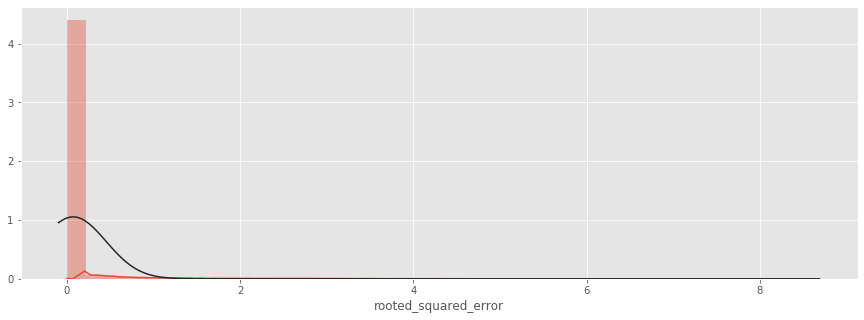

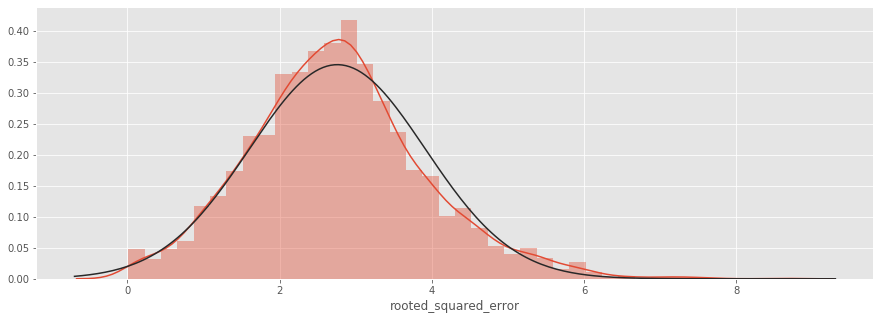

In [215]:
my_results_df = create_results_df(model, X_test, y_test)

In [216]:
my_results_df.sort_values(by='Target', ascending=False).head(10)

Target  Prediction  squared_error  \
fullVisitorId       visitId                                            
1957458976293878100 1491423580  10.048907    1.454192      73.869138   
                    1491578402   8.828781    1.478332      54.029107   
                    1492527922   8.633275    1.631820      49.020376   
2969957690756250633 1490305208   8.342721    0.890054      55.542242   
9817395183603701442 1472145168   8.315444    2.868312      29.671247   
6226617329849661943 1492779203   7.966049    2.725664      27.461633   
2517364798811740879 1477009448   7.913539    0.254919      58.654460   
5590743844926892757 1482162240   7.839715    0.859061      48.729524   
1044832976156649069 1474931750   7.783516    1.157131      43.908977   
1410336440849356236 1479365088   7.598900    3.232300      19.067199   

                                rooted_squared_error  
fullVisitorId       visitId                           
1957458976293878100 1491423580              8.594716  
                    1491578402              7.350449  
                    1492527922              7.001455  
2969957690756250633 1490305208              7.452667  
9817395183603701442 1472145168              5.447132  
6226617329849661943 1492779203              5.240385  
2517364798811740879 1477009448              7.658620  
5590743844926892757 1482162240              6.980654  
1044832976156649069 1474931750              6.626385  
1410336440849356236 1479365088              4.366600

### Vamos a trabajar con un nuevo DF rebalanceado

In [219]:
df_dev_zero = df_dev[df_dev['totals.transactionRevenueLN'] == 0]

In [220]:
df_dev_zero.describe().T

,count,mean,std,min,25%,50%,75%,max
visitNumber,756212.0,2.253674,9.401734,1.000000,1.000000,1.000000,1.000000,387.000000
device.isMobile,756212.0,0.250856,0.433506,0.000000,0.000000,0.000000,1.000000,1.000000
totals.hits,756212.0,4.216930,8.476959,1.000000,1.000000,2.000000,4.000000,500.000000
totals.pageviews,756212.0,3.554735,6.119339,0.000000,1.000000,1.000000,3.000000,429.000000
totals.transactionRevenueLN,756212.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
totals.hitsLN,756212.0,1.238854,0.750293,0.693147,0.693147,1.098612,1.609438,6.216606
year,756212.0,2016.429751,0.495041,2016.000000,2016.000000,2016.000000,2017.000000,2017.000000
month,756212.0,7.066179,3.774104,1.000000,3.000000,8.000000,11.000000,12.000000
day,756212.0,15.705880,8.793660,1.000000,8.000000,16.000000,23.000000,31.000000
weekDay,756212.0,2.734311,1.929275,0.000000,1.000000,3.000000,4.000000,6.000000


In [223]:
df_dev_zero.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 756212 entries, (1131660440785968503, 1472830385) to (0814900163617805053, 1483574474)
Columns: 144 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(5), int64(13), uint8(126)
memory usage: 212.7+ MB


In [221]:
df_dev_non_zero = df_dev[df_dev['totals.transactionRevenueLN'] != 0]

In [222]:
df_dev_non_zero.describe().T

,count,mean,std,min,25%,50%,75%,max
visitNumber,9495.0,3.976830,10.381124,1.000000,1.000000,2.000000,4.000000,293.000000
device.isMobile,9495.0,0.087520,0.282610,0.000000,0.000000,0.000000,0.000000,1.000000
totals.hits,9495.0,37.128910,31.876880,2.000000,19.000000,29.000000,45.000000,500.000000
totals.pageviews,9495.0,29.028963,22.989013,2.000000,16.000000,23.000000,35.000000,469.000000
totals.transactionRevenueLN,9495.0,4.062981,1.161682,0.009950,3.257712,3.946231,4.716980,10.048907
totals.hitsLN,9495.0,3.432071,0.614422,1.098612,2.995732,3.401197,3.828641,6.216606
year,9495.0,2016.456135,0.498098,2016.000000,2016.000000,2016.000000,2017.000000,2017.000000
month,9495.0,6.982728,3.724660,1.000000,4.000000,8.000000,10.000000,12.000000
day,9495.0,15.471722,8.636811,1.000000,8.000000,15.000000,23.000000,31.000000
weekDay,9495.0,2.488784,1.839704,0.000000,1.000000,2.000000,4.000000,6.000000


In [224]:
df_dev_non_zero.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9495 entries, (6194193421514403509, 1472843572) to (9771437221362506189, 1483538997)
Columns: 144 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(5), int64(13), uint8(126)
memory usage: 14.7+ MB


In [225]:
non_zero_indexes = df_dev_non_zero.shape[0]

In [226]:
non_zero_indexes

9495

In [227]:
df_dev_zero_sample = df_dev_zero.sample(n=non_zero_indexes, random_state=42)

In [229]:
df_dev_zero_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
visitNumber,9495.0,2.160295,8.636737,1.000000,1.000000,1.000000,1.000000,285.000000
device.isMobile,9495.0,0.250132,0.433111,0.000000,0.000000,0.000000,1.000000,1.000000
totals.hits,9495.0,4.173354,8.336121,1.000000,1.000000,2.000000,4.000000,279.000000
totals.pageviews,9495.0,3.508057,5.752836,0.000000,1.000000,1.000000,3.000000,141.000000
totals.transactionRevenueLN,9495.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
totals.hitsLN,9495.0,1.240922,0.744029,0.693147,0.693147,1.098612,1.609438,5.634790
year,9495.0,2016.423486,0.494137,2016.000000,2016.000000,2016.000000,2017.000000,2017.000000
month,9495.0,7.109637,3.736994,1.000000,4.000000,8.000000,10.000000,12.000000
day,9495.0,15.583465,8.849927,1.000000,8.000000,16.000000,23.000000,31.000000
weekDay,9495.0,2.697841,1.924368,0.000000,1.000000,3.000000,4.000000,6.000000


In [230]:
frames = [df_dev_non_zero, df_dev_zero_sample]
df_dev_sample = pd.concat(frames)

In [231]:
df_dev_sample.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18990 entries, (6194193421514403509, 1472843572) to (5308735748852977533, 1471030899)
Columns: 144 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(5), int64(13), uint8(126)
memory usage: 5.2+ MB


In [232]:
df_dev_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
visitNumber,18990.0,3.068562,9.591698,1.000000,1.000000,1.000000,3.000000,293.000000
device.isMobile,18990.0,0.168826,0.374608,0.000000,0.000000,0.000000,0.000000,1.000000
totals.hits,18990.0,20.651132,28.536224,1.000000,2.000000,13.000000,29.000000,500.000000
totals.pageviews,18990.0,16.268510,21.062238,0.000000,1.000000,11.000000,24.000000,469.000000
totals.transactionRevenueLN,18990.0,2.031491,2.191321,0.000000,0.000000,0.004975,3.945699,10.048907
totals.hitsLN,18990.0,2.336497,1.290686,0.693147,1.098612,2.639057,3.401197,6.216606
year,18990.0,2016.439810,0.496377,2016.000000,2016.000000,2016.000000,2017.000000,2017.000000
month,18990.0,7.046182,3.731274,1.000000,4.000000,8.000000,10.000000,12.000000
day,18990.0,15.527593,8.743967,1.000000,8.000000,16.000000,23.000000,31.000000
weekDay,18990.0,2.593312,1.885363,0.000000,1.000000,2.000000,4.000000,6.000000


In [233]:
df_dev_sample_X = df_dev_sample.drop(TARGET, axis=1)
df_dev_sample_y = df_dev_sample[TARGET]

In [234]:
X_train, X_test, y_train, y_test = train_test_split(df_dev_sample_X, df_dev_sample_y, test_size=0.3, random_state=42)

In [236]:
X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13293 entries, (9880284115430195099, 1478471676) to (163329501703961778, 1482926566)
Columns: 143 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(4), int64(13), uint8(126)
memory usage: 3.7+ MB


In [237]:
X_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5697 entries, (1627208831212925916, 1485477973) to (3868696346876688478, 1473968066)
Columns: 143 entries, visitNumber to trafficSource.adContent_Others
dtypes: float64(4), int64(13), uint8(126)
memory usage: 1.7+ MB


In [238]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test  = lgb.Dataset(X_test, label=y_test)

In [245]:
params = {
        'objective' : 'regression',
        'metric' : 'mse',  
        'learning_rate' : 0.1,
        'bagging_fraction' : 0.7,
        'feature_fraction' : 0.5,
        'max_depth': 5
}

In [246]:
%%time 
model = lgb.train(params, lgb_train, 1000, valid_sets=[lgb_test], early_stopping_rounds=5, verbose_eval=100)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 0.947322
CPU times: user 153 ms, sys: 4.65 ms, total: 158 ms
Wall time: 159 ms


Construyendo DataFrame de resultados
Mean Squared Error: 0.9473216382304642
Root Mean Squared Error: 0.5617952534339153
Mean Absolute Percentage Error: 0.2791791137776038
Imprimiento distribución del error (TOTAL)


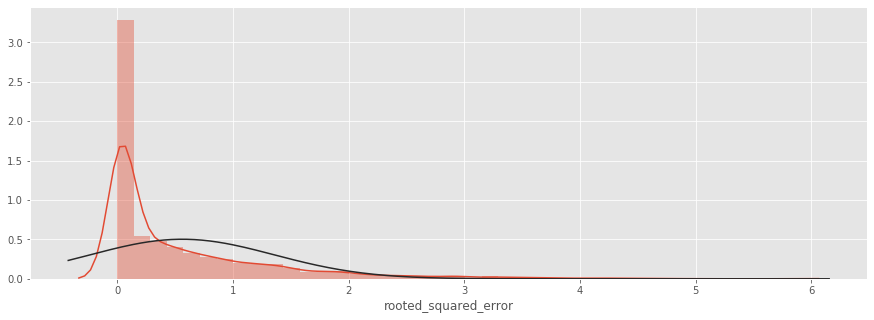

Imprimiento distribución del error (SÓLO POSITIVOS)


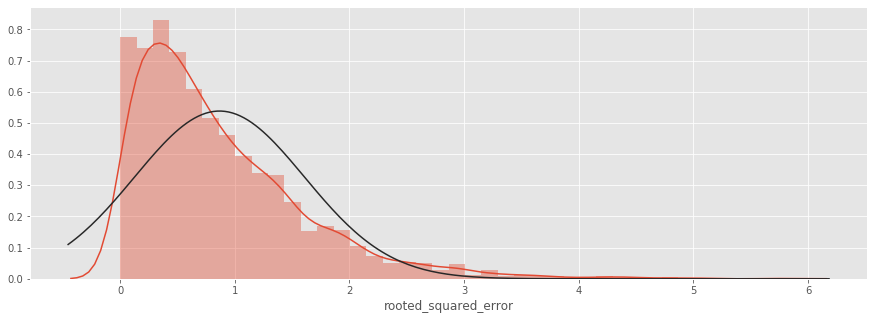

In [247]:
my_results_df = create_results_df(model, X_test, y_test)

In [249]:
my_results_df.head(20)

,,Target,Prediction,squared_error,rooted_squared_error
fullVisitorId,visitId,,,,
1627208831212925916,1485477973,3.446489,3.676340,0.052832,0.229851
5578387737890138053,1494860533,0.000000,0.709119,0.502849,0.709119
6565636910376220215,1495209879,2.659560,3.358975,0.489182,0.699415
2869565026097182177,1474104574,0.000000,-0.007308,0.000053,0.007308
3861180496381149226,1471611819,3.347445,2.649246,0.487481,0.698199
0343104487250705794,1487132331,5.484548,3.223177,5.113797,2.261371
3938948189416088055,1476457618,0.000000,0.001418,0.000002,0.001418
451553078414734725,1472277511,0.000000,0.028648,0.000821,0.028648
214415686397071336,1495755875,3.561330,3.990670,0.184332,0.429340


#### Optimize Hyperparameters

In [271]:
params = {
        'objective' : 'regression',
        'metric' : 'rmse',  
        'learning_rate' : 0.01,
        'bagging_fraction' : 0.7,
        'feature_fraction' : 0.5,
        'max_depth': 5
}

In [272]:
%%time 
model = lgb.train(params, lgb_train, 1000, valid_sets=[lgb_test], early_stopping_rounds=5, verbose_eval=20)

Training until validation scores don't improve for 5 rounds
[20]	valid_0's rmse: 1.89799
[40]	valid_0's rmse: 1.66537
[60]	valid_0's rmse: 1.48286
[80]	valid_0's rmse: 1.35026
[100]	valid_0's rmse: 1.24772
[120]	valid_0's rmse: 1.17138
[140]	valid_0's rmse: 1.11705
[160]	valid_0's rmse: 1.07904
[180]	valid_0's rmse: 1.05079
[200]	valid_0's rmse: 1.03017
[220]	valid_0's rmse: 1.01555
[240]	valid_0's rmse: 1.00454
[260]	valid_0's rmse: 0.996627
[280]	valid_0's rmse: 0.99028
[300]	valid_0's rmse: 0.985849
[320]	valid_0's rmse: 0.9826
[340]	valid_0's rmse: 0.980063
[360]	valid_0's rmse: 0.978352
[380]	valid_0's rmse: 0.977019
[400]	valid_0's rmse: 0.975675
[420]	valid_0's rmse: 0.974592
[440]	valid_0's rmse: 0.973979
[460]	valid_0's rmse: 0.973602
[480]	valid_0's rmse: 0.973353
[500]	valid_0's rmse: 0.973108
[520]	valid_0's rmse: 0.972888
[540]	valid_0's rmse: 0.972584
[560]	valid_0's rmse: 0.972343
[580]	valid_0's rmse: 0.972129
Early stopping, best iteration is:
[592]	valid_0's rmse: 0.9

In [273]:
model

In [275]:
feature_importance_df = pd.DataFrame(model.feature_importance(), index=X_test.columns, columns=['Importance'])

In [276]:
feature_importance_df.head()

,Importance
visitNumber,1181
device.isMobile,180
totals.hits,1561
totals.pageviews,1694
totals.hitsLN,740


In [277]:
feature_importance_df.sort_values(by='Importance', ascending=False)

,Importance
totals.pageviews,1694
totals.hits,1561
visitNumber,1181
week,1087
visitHour,893
totals.pageviewsLN,830
day,741
totals.hitsLN,740
visitNumberLN,509
weekDay,441


In [278]:
feature_importance_df['Rel. Importance'] = 100 * feature_importance_df['Importance'] / feature_importance_df['Importance'].max()

In [283]:
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

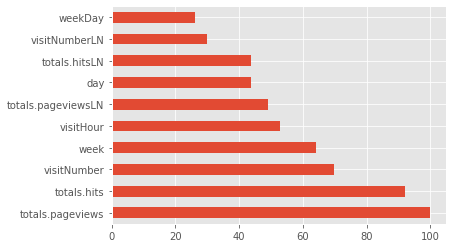

In [285]:
top_features['Rel. Importance'].plot(kind='barh')

In [281]:
my_results_df.head()

,,Target,Prediction,squared_error,rooted_squared_error
fullVisitorId,visitId,,,,
1627208831212925916,1485477973,3.446489,3.676340,0.052832,0.229851
5578387737890138053,1494860533,0.000000,0.709119,0.502849,0.709119
6565636910376220215,1495209879,2.659560,3.358975,0.489182,0.699415
2869565026097182177,1474104574,0.000000,-0.007308,0.000053,0.007308
3861180496381149226,1471611819,3.347445,2.649246,0.487481,0.698199


### Hyperparameter Tuning

In [258]:
model = xgb.XGBRFRegressor(random_state=42)

In [260]:
params_grid = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [100, 500, 1000],
    'min_child_weight': [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [261]:
from sklearn.model_selection import GridSearchCV

In [267]:
grid_search = GridSearchCV(
    model,
    params_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

In [269]:
## grid_search.fit(df_dev_sample_X, df_dev_sample_y)

In [270]:
# grid_search.best_estimator_

### Decision Tree

In [286]:
from sklearn import tree

In [288]:
dt = tree.DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)

In [310]:
%%time
dt.fit(X_train, y_train)

CPU times: user 40 ms, sys: 2.37 ms, total: 42.4 ms
Wall time: 41.4 ms


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Construyendo DataFrame de resultados
Mean Squared Error: 1.1866498394136822
Root Mean Squared Error: 0.6098989804315338
Mean Absolute Percentage Error: 0.3030838295802172
Imprimiento distribución del error (TOTAL)


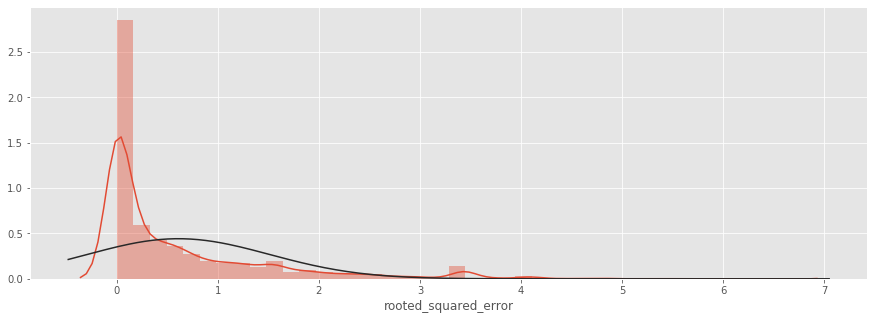

Imprimiento distribución del error (SÓLO POSITIVOS)


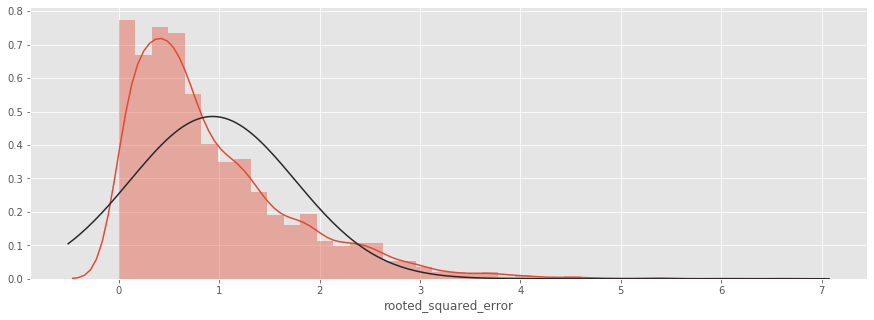

In [292]:
dt_results_df = create_results_df(dt, X_test, y_test)

In [293]:
dt_results_df.head()

,,Target,Prediction,squared_error,rooted_squared_error
fullVisitorId,visitId,,,,
1627208831212925916,1485477973,3.446489,4.095694,0.421467,0.649205
5578387737890138053,1494860533,0.000000,1.558951,2.430330,1.558951
6565636910376220215,1495209879,2.659560,3.439105,0.607691,0.779545
2869565026097182177,1474104574,0.000000,0.005671,0.000032,0.005671
3861180496381149226,1471611819,3.347445,3.439105,0.008402,0.091660


In [294]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz

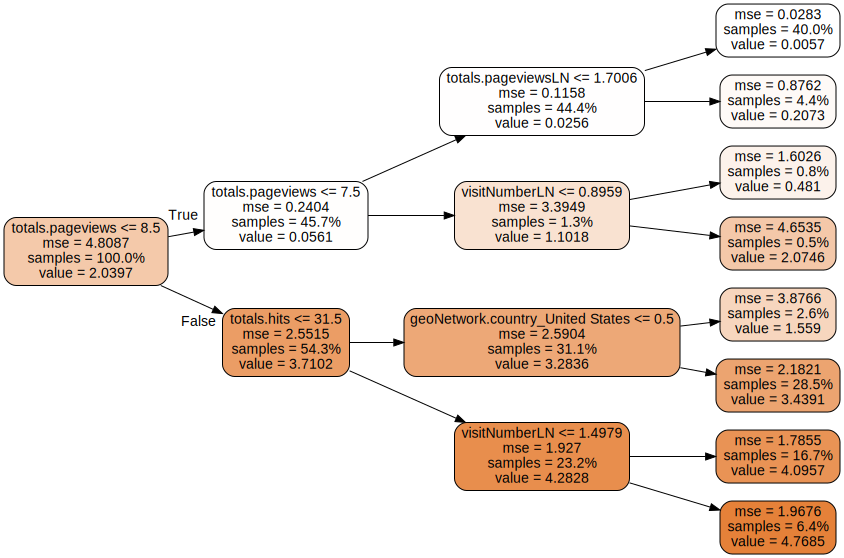

In [296]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        # out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

graph = graphviz.Source(dot_data)
graph

In [298]:
y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
totals.transactionRevenueLN,13293.0,2.03971,2.19296,0.0,0.0,1.095273,3.950859,10.048907


In [302]:
df.pivot_table(index=['totals.pageviews'], values=['totals.transactionRevenueLN'], aggfunc=[len, np.mean])

,len,mean
,totals.transactionRevenueLN,totals.transactionRevenueLN
totals.pageviews,,
0,100.0,0.000000
1,452522.0,0.000000
2,143770.0,0.000128
3,73835.0,0.000168
4,45192.0,0.000684
5,33411.0,0.001686
6,24688.0,0.001260
7,19476.0,0.004991


In [299]:
df['totals.pageviews_rank'] = np.floor(df['totals.pageviews'] / 10)

In [300]:
df[['totals.pageviews','totals.pageviews_rank']]

,,totals.pageviews,totals.pageviews_rank
fullVisitorId,visitId,,
1131660440785968503,1472830385,1,0.0
377306020877927890,1472880147,1,0.0
3895546263509774583,1472865386,1,0.0
4763447161404445595,1472881213,1,0.0
27294437909732085,1472822600,1,0.0
...,...,...,...
5123779100307500332,1483554750,15,1.0
7231728964973959842,1483543798,13,1.0
5744576632396406899,1483526434,21,2.0


In [303]:
df.pivot_table(index=['totals.pageviews_rank'], values=['totals.transactionRevenueLN'], aggfunc=[len, np.mean])

,len,mean
,totals.transactionRevenueLN,totals.transactionRevenueLN
totals.pageviews_rank,,
0.0,820851.0,0.001323
1.0,55433.0,0.279828
2.0,15698.0,0.821291
3.0,5960.0,1.275570
4.0,2645.0,1.533606
5.0,1315.0,1.662207
6.0,688.0,1.744030
7.0,378.0,1.784236


### LinearRegression

In [304]:
from sklearn.linear_model import LinearRegression

In [307]:
lm = LinearRegression()

In [309]:
%%time
lm.fit(X_train, y_train)

CPU times: user 106 ms, sys: 6.51 ms, total: 113 ms
Wall time: 33.2 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Construyendo DataFrame de resultados
Mean Squared Error: 1.3306417957335364
Root Mean Squared Error: 0.8513239853249538
Mean Absolute Percentage Error: 0.4230578209906432
Imprimiento distribución del error (TOTAL)


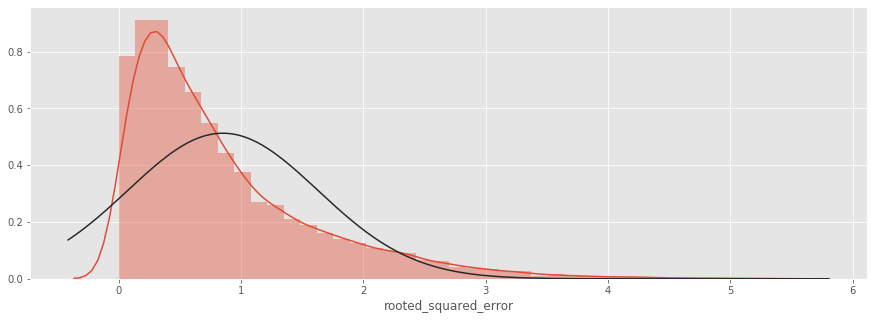

Imprimiento distribución del error (SÓLO POSITIVOS)


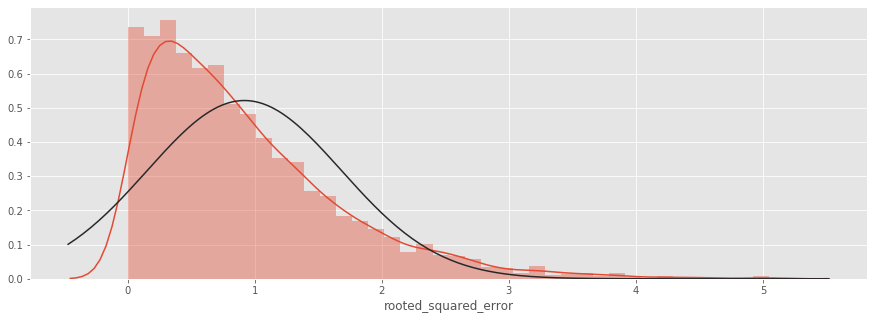

In [313]:
lr_results_df = create_results_df(lm, X_test, y_test)

In [314]:
lr_results_df.head(20)

,,Target,Prediction,squared_error,rooted_squared_error
fullVisitorId,visitId,,,,
1627208831212925916,1485477973,3.446489,3.764211,0.100947,0.317722
5578387737890138053,1494860533,0.000000,2.135558,4.560606,2.135558
6565636910376220215,1495209879,2.659560,2.916947,0.066248,0.257387
2869565026097182177,1474104574,0.000000,-0.416231,0.173248,0.416231
3861180496381149226,1471611819,3.347445,2.245725,1.213788,1.101720
0343104487250705794,1487132331,5.484548,3.035382,5.998416,2.449166
3938948189416088055,1476457618,0.000000,-0.138590,0.019207,0.138590
451553078414734725,1472277511,0.000000,-0.041074,0.001687,0.041074
214415686397071336,1495755875,3.561330,4.146678,0.342633,0.585348


In [321]:
lm.coef_

array([[-8.38912047e-03,  6.41711897e-02,  8.19246104e-03,
        -1.48013709e-02, -5.93652274e-01,  3.15918689e-01,
         4.01478459e-02,  9.58549100e-04, -1.37219959e-02,
         6.13013735e-02, -7.72752360e-03,  9.38206902e-03,
         5.00628893e-01,  2.02751147e+00,  1.26698189e-05,
        -6.19379705e-03, -1.36347185e-01, -9.15203020e-02,
        -5.53648830e-04,  1.81547237e-02,  1.03834478e-01,
        -4.09256716e-02,  6.47382203e-02, -2.91827513e-02,
        -2.45450477e-02,  1.02132140e-01, -1.06984120e-01,
         6.26927001e-02, -1.19658525e-02, -1.21202542e-01,
         7.53276740e-02,  4.91765247e-02,  2.59251698e-01,
        -3.61463697e-01, -1.70203717e-01, -9.58180663e-02,
         4.23913031e-01, -1.04855773e-01, -4.68820366e-02,
         2.05535917e-04,  4.66765007e-02,  5.06220627e-01,
         9.46832101e-02,  6.79507523e-02,  9.34947033e-02,
         1.57754259e-01, -9.20103551e-01,  5.06220627e-01,
         7.46901155e-01,  9.73013419e-02, -2.06488515e-0

In [328]:
lm_feature_importance_df = pd.DataFrame(lm.coef_.T, index=X_test.columns, columns=['Coefficient'])

In [326]:
lm_feature_importance_df.head()

,Coefficient
visitNumber,-0.008389
device.isMobile,0.064171
totals.hits,0.008192
totals.pageviews,-0.014801
totals.hitsLN,-0.593652


In [341]:
X_test.head(1).T

fullVisitorId,1627208831212925916
visitId,1485477973
visitNumber,1.000000
device.isMobile,0.000000
totals.hits,36.000000
totals.pageviews,29.000000
totals.hitsLN,3.610918
year,2017.000000
month,1.000000
day,26.000000
weekDay,3.000000


In [339]:
(X_test.iloc[0]*lm_feature_importance_df['Coefficient']).sum()+lm.intercept_

array([3.76421092])

In [338]:
lm.predict(X_test)

array([[ 3.76421092],
       [ 2.13555764],
       [ 2.9169469 ],
       ...,
       [ 0.68206891],
       [-0.2829243 ],
       [ 4.07704985]])

#### RandomForest

In [315]:
from sklearn.ensemble import RandomForestRegressor

In [316]:
rf = RandomForestRegressor(max_depth=3, random_state=RANDOM_STATE)

In [319]:
rf.fit(X_train, np.ravel(y_train))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Construyendo DataFrame de resultados
Mean Squared Error: 1.1382085851714627
Root Mean Squared Error: 0.5961876501035883
Mean Absolute Percentage Error: 0.29627010691832206
Imprimiento distribución del error (TOTAL)


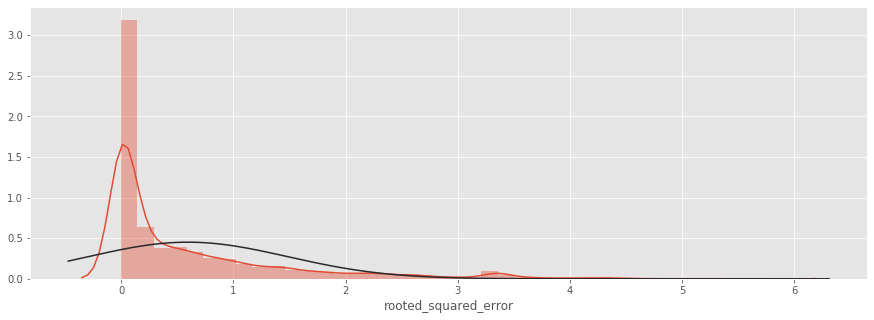

Imprimiento distribución del error (SÓLO POSITIVOS)


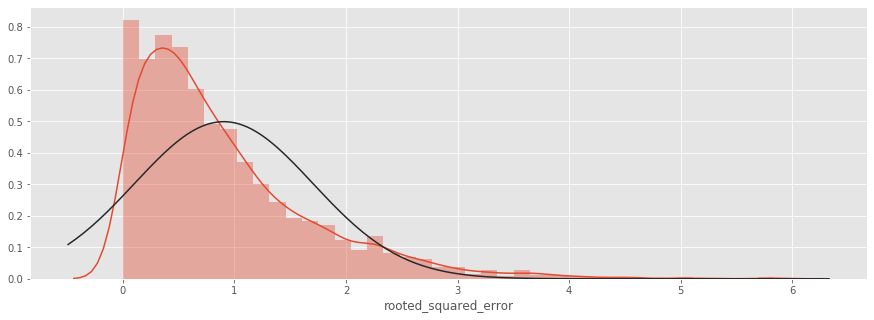

In [320]:
rf_results_df = create_results_df(rf, X_test, y_test)

#### Me quedo con el LighGBM

In [342]:
model

Construyendo DataFrame de resultados
Mean Squared Error: 0.6317891815675657
Root Mean Squared Error: 0.2706645596974686
Mean Absolute Percentage Error: 4.686681099902777
Imprimiento distribución del error (TOTAL)


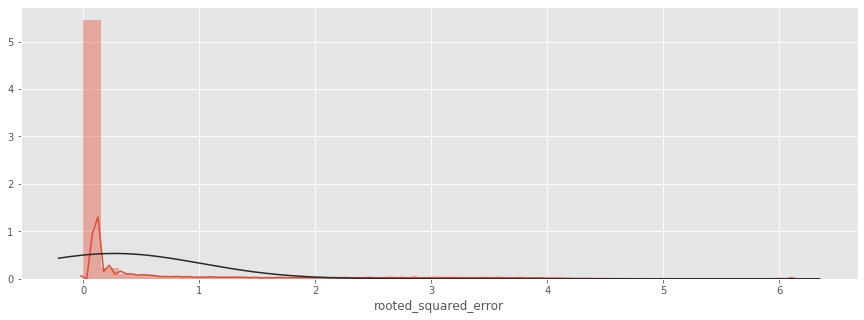

Imprimiento distribución del error (SÓLO POSITIVOS)


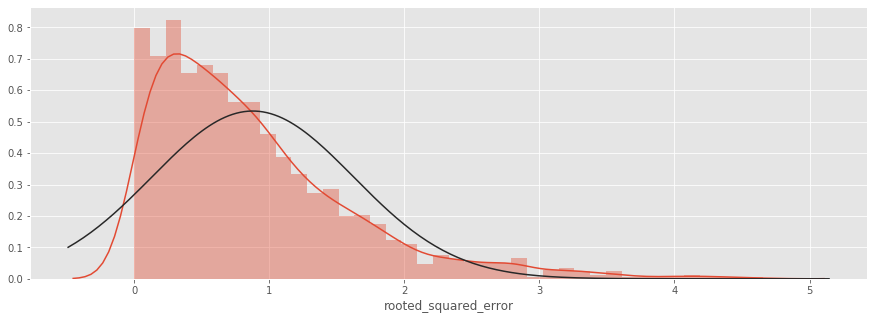

In [343]:
lgb_val_results = create_results_df(model, df_val_X, df_val_y)

In [347]:
lgb_val_results.sort_values(by='Target', ascending=False).head(100)

,,Target,Prediction,squared_error,rooted_squared_error
fullVisitorId,visitId,,,,
9417857471295131045,1500404409,9.267679,4.969423,18.475004,4.298256
79204932396995037,1497904048,8.740297,4.084944,21.672305,4.655352
9026840718082010040,1498050723,8.612322,4.491952,16.977446,4.120370
4604965471651937146,1498684104,8.362105,4.542353,14.590510,3.819753
6236695646664370912,1499275131,8.296686,4.960321,11.131331,3.336365
9308310352918219134,1501608078,7.984330,5.093887,8.354659,2.890443
9417857471295131045,1499951313,7.843653,5.493077,5.525204,2.350575
1957458976293878100,1498670564,7.822445,3.839724,15.862065,3.982721
7445235885559107095,1501533749,7.820440,3.696211,17.009264,4.124229
